## Notebook roadmap <a id="menu"></a>


This notebook is organized as follows (links are clickable):
   

1. Presentation of [the setup](#Setup)

2. Setting up [the calibration](#Calibration)

3. Solving [the Aiyagari model](#Aiyagari)

4. Checking [the consistency of the Aiyagari solution](#Checking-Aiyagari)

5. [Estimating](#Estimation) the model parameters

6. [Numerical applications](#Numerical-applications)


## Date: August 14th, 2024

# Organization and summary of the computational solution  <a id="summary-computational-solution"></a>[<font size=1>(back to menu)</font>](#menu)



1. [**Main.ipynb**](./Main.ipynb) (the current notebook): calls external functions and allows the computation of the steady-state solution for a given calibration. This is the only notebook that actually needs to be run. 

## The steady-state computation [<font size=1>(back to organization)</font>](#summary-computational-solution) <a id="summary-computational-solution-ss"></a>

The computation of the solution at the steady state is organized into 3 additional notebooks.



2. [**Structures.ipynb**](./Structures.ipynb): contains the definitions of the main structures used by the computational implementation, as well as some specific constructors. The structures are:
* `Economy`: collects the parameters that characterize the economy (utility and related functions, productivity process, grids, $\ldots$).
* `AiyagariSolution`: contains the solution of the individual Aiyagari model (prices, policy functions, $\ldots$).

3. [**Aiyagari.ipynb**](./Aiyagari.ipynb): computes the solution of the individual Aiyagari model using the EGM method. The implemented solution takes  prices (interest rate and thus wage rate) as given and returns the level of public spending  that allows the government budget to balance. Public debt is also an endogenous result of the model allowing the financial market to clear. The core function of this notebook is **`steady`** which takes an economy of type `Economy`  as input and returns the solution of the Aiyagari model as type `AiyagariSolution`. The signature of the function is:
> `steady(economy::Economy)::AiyagariSolution`

4. [**Utils.ipynb**](./Utils.ipynb): contains useful functions that are not central to the algorithm (such as computing a Gini index or our linearization implementation). They are collected in the same notebook for the sake of convenience. 


## Estimating the model <a id="summary-estimation"></a>[<font size=1>(back to organization)</font>](#summary-computational-solution)



# Computing the steady state equilibrium <a id="solving-steady-state"></a>[<font size=1>(back to menu)</font>](#menu)

We start with importing [external packages](#Ext-packages) and [other notebooks](#Other-nb). The rest is organized as follows:

1. Presentation of [the setup](#Setup)

2. Setting up [the calibration](#Calibration)

3. Solving [the Aiyagari model](#Aiyagari)

4. Checking [the consistency of the Aiyagari solution](#Checking-Aiyagari)

5. [Estimating](#Estimation) the model parameters

6. [Numerical applications](#Numerical-applications)

## Importing external packages <a id="Ext-packages"></a>[<font size=1>(back to steady state)</font>](#solving-steady-state)

We import the external modules we use. In some cases we specify which functions we use. Note that these imports are valid for all notebooks (but should be repeated if you want to run other notebooks independently).

In [1]:
using Parameters                     # @unpack
using QuantEcon:rouwenhorst,tauchen,MarkovChain  # Rouwenhorst + Tauchen
using Roots:find_zero                # root finding
using SparseArrays                   # sparse matrices
using LinearAlgebra:I
using IterativeSolvers:powm!         # largest eigenvector + associated eigenvector
using Plots                          # Plots
using DataInterpolations                 # linear interpolations
using NBInclude                      # including notebooks instead of jl files
using CSV
using DataFrames
using Statistics
using Optim
using Roots

## Including other notebooks <a id="Other-nb"></a>[<font size=1>(back to steady state)</font>](#solving-steady-state)

See above for a detailed description of each notebook. We will briefly recall them:
* [**Structures.ipynb**](./Structures.ipynb). Main structures: `Economy`, `AiyagariSolution`.

* [**SolveAiyagari.ipynb**](./SolveAiyagari.ipynb). Solves  the individual Aiyagari model. Core function:  `steady(economy::Economy)::AiyagariSolution`.

* [**Utils.ipynb**](./Utils.ipynb). Miscellaneous functions. 


In [3]:
@nbinclude("Structures_endo_effort.ipynb");
@nbinclude("Utils.ipynb"); 
@nbinclude("SolveAiyagari_endo_effort.ipynb");

## The setup <a id="Setup"></a>[<font size=1>(back to steady state)</font>](#solving-steady-state)

Here we briefly recall the setup we are using and link the model presented in the paper to its implementation. 
Further details can be found in the paper. 

We consider an economy populated by a continuum of households of mass 1 indexed by $i$ and distributed with measure $\ell$. 
        
### Idiosyncratic risk
The productivity risk is denoted by $y$ and modeled as a first-order Markov process with state-space `ys::Vector{T}` and transition matrix `Πy::Matrix{T}`. There are `ny::I` idiosyncratic states. More generally, variables ending in `...y` refer to the productivity.

### Households
Household $i$ chooses its consumption $(c_{i,t})_t$ and its savings $(a_{i,t})_t$, so as to maximize their expected utility subject to a bugdet constraint and a credit constraint:
\begin{align}
&\max_{\{c_{i,t},a_{i,t}\}_{t=0}^{\infty}}\mathbb{E}_{0}\sum_{t=0}^{\infty}\beta^{t}\frac{c_{i,t}^{1-\sigma}-1}{1-\sigma},\\
&c_{i,t}+a_{i,t}\leq w_{t}y_{i,t} + R_{t} a_{i,t-1},\\
&a_{i,t}\geq 0,\ c_{i,t}>0,\ l_{i,t}\ge 0.
\end{align}

# Estimation

## Data

### Income

In [4]:
df_income = CSV.read("data/income_data.csv",DataFrame)
months  = df_income.month
incomes = df_income.disposable_income
#savings = df_income.savings
consos  = df_income.spendings;

savings = incomes - consos;

πeu_q = 1.8/100;
πre_q = 11.0/100;
πur_m = 1.0/18;

R_m = 1.0;

### Job finding rates $\pi_{ue}$

In [5]:
df_proba = CSV.read("data/hazard_rate.csv",DataFrame)
months_  = df_proba.month
@assert all(months .== months_)
πue_ms = df_proba.mean
tmp_i = findfirst(πue_ms.>0.)
πue_m = mean(πue_ms[tmp_i+1:end]);

## Normalizing data

We normalize data such that the average income of the "regular" employed period is equal to 1. 

We detect the regular employment period as the early period of the income data that stops once the income variation exceeds a given threshold. There are $n_e$ regular employment dates.

We also detect the regular unemployment period as the late period of the income data that stops once the income variation exceeds a given threshold. There are $n_u$ regular employment dates.
 
We construct the vector `raw_indices_y` as the vector containing:
* first, $n_e$ times the index 2 indicating employment,
* then, $n_u$ times the index 1 indicating unemployment.

The vector are therefore $n_e+n_u$ elements.

The difference between the number of data points and $n_e+n_u$ is the number of transition periods, from employment to unemployment. It is called `times_to_u`.

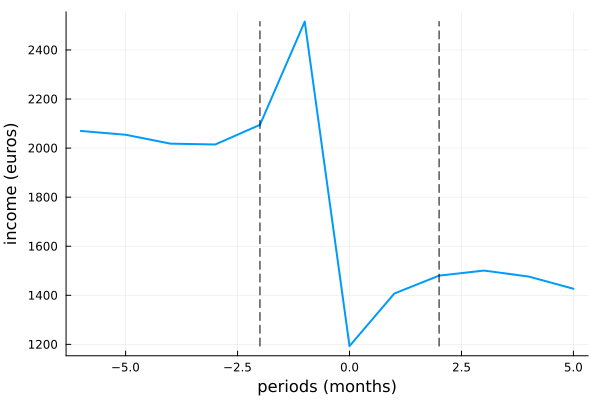

In [6]:
var_incomes = zeros(eltype(incomes),length(incomes)-1)
for t in eachindex(var_incomes)
    var_incomes[t] = incomes[t+1]/incomes[t] - 1
end

# We choose the cutoff of a 2% monthly variation to detect the end of the "regular" employment period
# We choose the cutoff of a 4% monthly variation to detect the beginning of the "regular" unemployment period

cutoff_e = 0.04
times_e = findfirst(abs.(var_incomes).>cutoff_e)
cutoff_u = 0.04
times_u = findlast(abs.(var_incomes).>cutoff_u)+1

# We plot incomes and check that the threshold are ok
q = plot(months,incomes,lw=2,label=nothing,ylabel="income (euros)",xlabel="periods (months)")
plot!(q,[months[times_e],months[times_e]],[minimum(incomes),maximum(incomes)],label=nothing,ls=:dash,lc=:black)
plot!(q,[months[times_u],months[times_u]],[minimum(incomes),maximum(incomes)],label=nothing,ls=:dash,lc=:black)
display(q)
savefig(q,"income_profile_cutoffs.png")
#
raw_indices_y = ones(Int64,times_e+length(months)-times_u+1)
raw_indices_y[1:times_e] .= 2

#extending the data
function extend(xs::Vector{T}, nxs::I, nxs′::I; step::T=zero(T)) where {T<:Number,I<:Int}
    @assert nxs ≥ one(I)
    xs′ = zeros(eltype(xs),nxs′)
    for k in eachindex(xs′)
        if k <= nxs
            xs′[k] = xs[k]
        else
            xs′[k] = xs′[k-1] + step
        end
    end
    return xs′
end

n0 = length(incomes)
n1 = n0 + 5
incomes = extend(incomes,n0,n1)
consos  = extend(consos,n0,n1)
savings = extend(savings,n0,n1)
πue_ms  = extend(πue_ms,n0,n1)
raw_indices_y = extend(raw_indices_y,length(raw_indices_y),length(raw_indices_y)+n1-n0)
months = extend(months,n0,n1,step=one(eltype(months)))

# normalizing data
y_ref = mean(incomes[1:times_e])
incomes_norm = incomes ./y_ref;
consos_norm  = consos ./y_ref;

## Calibrating income

The function 

> `f_income_path(path_to_u,raw_indices_y,incomes_norm)`

returns the Euclidian distance between the normalized income path of the data and the model one.


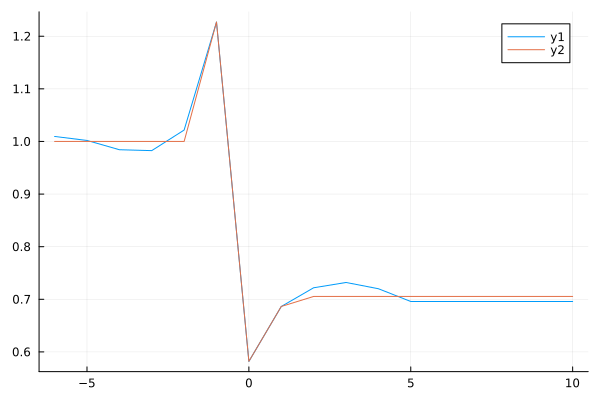

In [7]:
@nbinclude("Structures_endo_effort.ipynb");
function f_income_path(path_to_u,raw_indices_y,incomes_norm)
    @assert length(path_to_u) + length(raw_indices_y) == length(incomes_norm)+1
    #@show length(path_to_u), length(raw_indices_y), length(incomes_norm)
    economy = Economy(
        β=0.97,
        γ=2.0,
        χ=0.5,
        φ=1.,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,        
        times_to_u=length(path_to_u)-1,
        path_to_u=path_to_u,
        πeu=0.1,
        πec=0.001,
        πuc=0.01,
        πcu=0.01,
        πce=0.01,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
    full_indices_y = raw_to_full(raw_indices_y,economy)
    y_path = [economy.ys[iy] for iy in full_indices_y]
    return sum((y_path.-incomes_norm).^2)
end
res = optimize(x -> f_income_path(x,raw_indices_y,incomes_norm),
    zeros(Float64,length(incomes_norm)-length(raw_indices_y)+1))
path_to_u_res = Optim.minimizer(res)
economy = Economy(
        β=0.97,
        γ=2.0,
        χ=0.5,
        φ=1.,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=0.5,
        πec=0.,
        πuc=0.01,
        πcu=0.01,
        πce=0.01,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
full_indices_y = raw_to_full(raw_indices_y,economy)
y_path = [economy.ys[iy] for iy in full_indices_y]
q = plot(months, incomes_norm)
plot!(q,months,y_path)

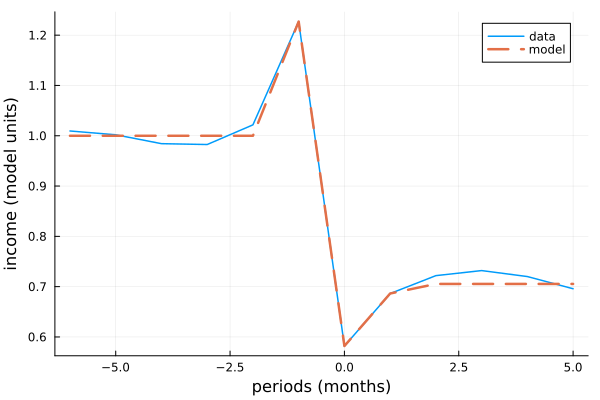

In [8]:
q = plot(months[1:end-5], incomes_norm[1:end-5],lw=1.5,label="data",ylabel="income (model units)",xlabel="periods (months)")
plot!(q,months[1:end-5],y_path[1:end-5],lw=2.5,label="model",ls=:dash)
display(q)
#savefig(q,"income_profile_calibration.png");

# Calibrating probabilities

We compute monthly probabilities from quarterly ones

## 3 states: e, u , r

In [9]:
function transition_q_m(πeu_q,πec_q,πuc_q,πce_q)
    function foo(πeu,πec,πuc,πce;πuc_q=πuc_q,πue=πue_m)
        eco = Economy(
        β=0.97,
        γ=2.0,
        χ=1.0,
        φ=0.5,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu,
        πec=πec,
        πuc=πuc,
        πce=πce,
        πcu=0.,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
        Πy_q = eco.Πy(πue)^3
        #=return (sum(Πy_q[end-1,1:end-2]) - πeu_q, 
                Πy_q[1,end-1] - πue_q)#,
               #Πy_q[end-1,end] - πec_q)#,
               # Πy_q[1,end] - πuc_q,
                # Πy_q[end,end-1] - πce_q)=#
        return 1e3*((sum(Πy_q[end-1,1:end-2]) - πeu_q)^2 + (Πy_q[end,end-1] - πce_q)^2 + 
            (Πy_q[end-1,end]-πec_q)^2 + (Πy_q[1,end]-πuc_q)^2)^0.5
    end
    #res  = nlsolve(x -> foo(x...),.1*ones(Float64,2))
    #return res.zero #Optim.minimizer(res)
    res  = optimize(x->foo(x...),map(x->1-(1-x)^(1/3.),[πeu_q,πec_q,πuc_q,πce_q]))
    xmin_res = Optim.minimizer(res)
    (res.minimum>1e-6)&&(@info "Problem in setting probas. Min = $res.minimum")
    if xmin_res[end-1] < zero(xmin_res[end-1])
        #@show xmin_res[end-1]
        function find_πuc(πuc)
            res′ = optimize(x->foo(x...,πuc_q=πuc),map(x->1-(1-x)^(1/3.),[πeu_q,πec_q,πuc,πce_q]))
            xmin_res′ = Optim.minimizer(res′)
            toR = xmin_res′[end-1]
            return toR < zero(toR) ? toR*1e6 : toR
        end
        #@show find_πuc(πuc_q),find_πuc(0.1)
        πuc_q′ = find_zero(find_πuc,[πuc_q,0.1])
        #@show πuc_q′,πuc_q
        res  = optimize(x->foo(x...,πuc_q=πuc_q′),map(x->1-(1-x)^(1/3.),[πeu_q,πec_q,πuc_q′,πce_q]))
        xmin_res = Optim.minimizer(res)
    end
    (minimum(xmin_res)<zero(typeof(πce_q)))&&(@info("Problem with negative probas. Sol = $xmin_res"))
    return xmin_res
end
πec_q,πuc_q,πce_q = 0.05,0.15,0.1
πeu_m,πec_m,πuc_m,πce_m = transition_q_m(πeu_q,πec_q,πuc_q,πce_q);
@show πeu_m,πue_m,πec_m,πuc_m
#[1-πeu_m πeu_m;πue_m 1-πue_m]^3  - [1-πeu_q πeu_q;πue_q 1-πue_q]
economy = Economy(
        β=0.97,
        γ=2.0,
        χ=1.0,
        φ=0.5,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu_m,
        πec=πec_m,
        πuc=πuc_m,
        πcu=0.,
        πce=πce_m,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);

Πy_q = economy.Πy(πue_m)^3
diffs = sum(Πy_q[end-1,1:end-2])-πeu_q,Πy_q[end,end-1]-πce_q,Πy_q[end-1,end]-πec_q, Πy_q[1,end]-πuc_q
@show diffs
@show maximum(abs.([diffs...]))#, Πy_q[1,end]-πuc_q
economy.Πy(πue_m)

(πeu_m, πue_m, πec_m, πuc_m) = (0.0061440232033339575, 0.18078491878758898, 0.01769535354630783, 0.06335242301799282)
diffs = (5.401297464846522e-12, -1.2526507608967563e-12, 4.9177606431527465e-12, -2.1773166603011873e-11)
maximum(abs.([diffs...])) = 2.1773166603011873e-11


6×6 Matrix{Float64}:
 0.755863  0.0  0.0  0.0         0.180785   0.0633524
 1.0       0.0  0.0  0.0         0.0        0.0
 0.0       1.0  0.0  0.0         0.0        0.0
 0.0       0.0  1.0  0.0         0.0        0.0
 0.0       0.0  0.0  0.00614402  0.976161   0.0176954
 0.0       0.0  0.0  0.0         0.0353907  0.964609

In [10]:
function get_Sy(πeu_q,πec_q,πuc_q,πce_q,πue_m=πue_m)
    πeu_m,πec_m,πuc_m,πce_m = transition_q_m(πeu_q,πec_q,πuc_q,πce_q);
    economy = Economy(
        β=0.97,
        γ=2.0,
        χ=1.0,
        φ=0.5,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu_m,
        πec=πec_m,
        πuc=πuc_m,
        πcu=0.,
        πce=πce_m,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
    return economy.Sy(πue_m)
end;

# Estimation of the model <a id="Estimation"></a> [<font size=1>(back to steady state)</font>](#solving-steady-state)

## Functions

The function 

>`pol_paths(raw_indices_y::Vector{T_I}, economy::Economy, solution::AiyagariSolution; 
        policy::Symbol=:gc)`
        
computes the path associated to the choice variable `policy` for the path of raw income indices `raw_indices_y` for the economy `economy` and the related Aiyagari solution `solution`.

In [11]:
function pol_paths(raw_indices_y::Vector{T_I}, economy::Economy, solution::AiyagariSolution; 
        policy::Symbol=:gc) where T_I<:Int
    full_path = raw_to_full(raw_indices_y,economy)
    if policy == :ys
        return [economy.ys[iy] for iy in full_path]
    end
    gx = getproperty(solution,policy)[:]'
    T = eltype(gx)
    path_gx = zeros(T,length(full_path))
    statD   = statD_i(full_path[1],solution)[:]'
    transM  = Matrix{T}(I, length(statD), length(statD))
    for i in eachindex(path_gx)
        if i > 1
            transM  = transM_i_j(full_path[i-1],full_path[i],solution)
        end
        statD = statD * transM
        path_gx[i] = sum(statD .* gx)/sum(statD)
    end
    return path_gx
end;

The function 
> `moments_conso(β,γ,R,πee,πuu; raw_indices_y=raw_indices_y)`

return the income and consumption paths asscoiated to the parameters `β`, `γ`, `R`, `πee`, `πuu` and the path of raw income indices `raw_indices_y`.

In [15]:
@nbinclude("Utils.ipynb")

a_size=10
a_min=1e-9
a_max=1e3
curv_a=4.0

β,γ,yc = 0.95, 1.5, 0.5

eco = Economy(β=β,γ=γ,χ=0.05,φ=1.0,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R_m,w=1.,Tt=0.);
sol = steady(eco, noprint=true,tolSD=1e-12)
#sol_u = AiyagariSolution(eco_u)
#euler_backward_EGM!(sol_u,eco_u)
#inverse_c_EGM!(sol_u, eco_u)
sol.gf
pol_paths([2,2,2,2,2,2,1,1,1,1,1,1,1,1], eco, sol; policy=:gf)

17-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.1699808313998938
 0.17028172685018791
 0.17053094674836602
 0.17074149110071038
 0.1709215568474064
 0.1710767107257203
 0.1712110060181482
 0.17132756832251322

### 3 states

In [16]:
function moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q;
        raw_indices_y=raw_indices_y,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πcu=0.,
        R=R_m,
        w=1.0,
        Tt=0.0,
        πeu_q=πeu_q,πue_m=πue_m)
    
    πeu_m,πec_m,πuc_m,πce_m = transition_q_m(πeu_q,πec_q,πuc_q,πce_q);
    
    eco_u = Economy(β=βs[1],γ=γs[1],χ=χs[1],φ=φs[1],a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    eco_l = Economy(β=βs[end],γ=γs[end],χ=χs[end],φ=φs[end],a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
 
    sol_u = steady(eco_u, noprint=true,tolSD=1e-12)
    sol_l = steady(eco_l, noprint=true,tolSD=1e-12)
    @assert check_solution(sol_u,eco_u,noprint=true)
    @assert check_solution(sol_l,eco_l,noprint=true)
    
    ys_u = pol_paths(raw_indices_y,eco_u,sol_u,policy=:ys)
    cs_u = pol_paths(raw_indices_y,eco_u,sol_u,policy=:gc)
    fs_u = pol_paths(raw_indices_y,eco_u,sol_u,policy=:gf)
    ys_l = pol_paths(raw_indices_y,eco_l,sol_l,policy=:ys)
    cs_l = pol_paths(raw_indices_y,eco_l,sol_l,policy=:gl)
    fs_l = pol_paths(raw_indices_y,eco_l,sol_l,policy=:gf)
    @assert all(ys_u.==ys_l)
    return (share_u .* cs_u)+((one(share_u)-share_u) .* cs_l),cs_u,cs_l,ys_u, 
        (share_u .* fs_u)+((one(share_u)-share_u) .* fs_l),fs_u,fs_l
end;

In [17]:
share_u,βs,γs,χs,φs,yc = 0.235, [0.99, 0.91], [1.5], [0.3],[1.0], 0.5
c_sol,c_u_sol,c_l_sol,_,f_sol,f_u_sol,f_l_sol = moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q)
ind_u = findfirst(months[2:end].>0)
f_l_sol[ind_u:end-1]

10-element Vector{Float64}:
 0.0
 0.0
 0.44001575790334124
 0.44068992722802813
 0.4412304597416526
 0.4416865401821476
 0.44207457811255263
 0.44240555063813514
 0.4426882886149292
 0.44293012463124454

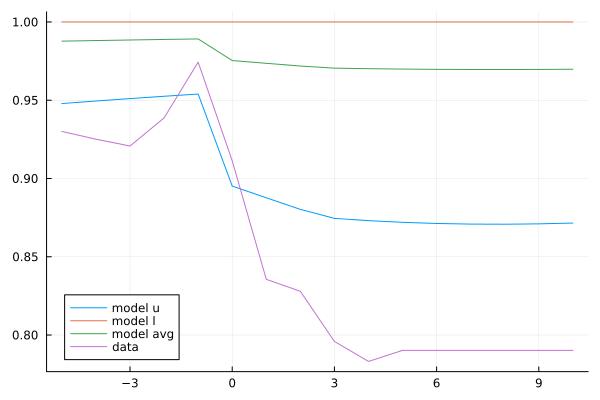

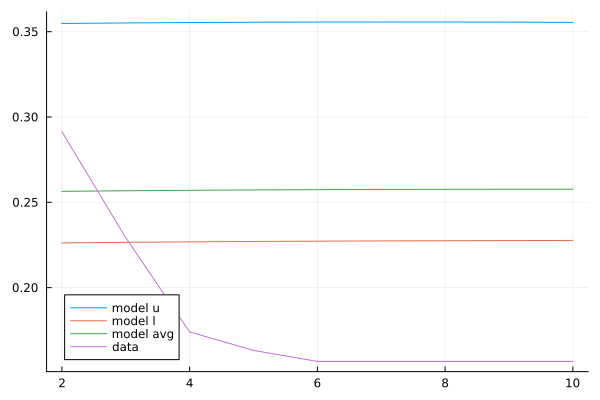

In [18]:
@nbinclude("SolveAiyagari_endo_effort.ipynb");
share_u,βs,γs,χs,φs,yc = 0.235, [0.99, 0.91], [1.2], [0.1],[1.0], 0.4

c_sol,c_u_sol,c_l_sol,_,f_sol,f_u_sol,f_l_sol = moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q)

q = plot(months[2:end],c_u_sol[1:end-1],label="model u")
plot!(q,months[2:end],c_l_sol[1:end-1],label="model l")
plot!(q,months[2:end],c_sol[1:end-1],label="model avg")
plot!(q,months[2:end],consos_norm[2:end],label="data")
display(q)
ind_u = findfirst(months[2:end].>0)
q = plot(months[ind_u+2:end],f_u_sol[ind_u+2:end],label="model u")
plot!(q,months[ind_u+2:end],f_l_sol[ind_u+2:end],label="model l")
plot!(q,months[ind_u+2:end],f_sol[ind_u+2:end],label="model avg")
plot!(q,months[ind_u+2:end],πue_ms[ind_u+1:end-1],label="data")
display(q)

In [19]:
function dist_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q;
        normalized=false,
        weights_c=nothing,
        weights_f=nothing,
        raw_indices_y=raw_indices_y,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πcu=0.,
        R=R_m,
        w=1.0,
        Tt=0.0,
        πeu_q=πeu_q,πue_m=πue_m)
    
    yc  = max(1e-6,yc)
    πec_q = min(1-1e-6,max(1e-6,πec_q))
    πuc_q = min(1-1e-6,max(1e-6,πuc_q))
    πce_q = min(1-1e-6,max(1e-6,πce_q))
    
    c_sol,_,_,_,f_sol,_,_ = moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q,
        raw_indices_y=raw_indices_y,
        a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=times_to_u,path_to_u=path_to_u,
        πcu=πcu,R=R,w=w,Tt=Tt,
        πeu_q=πeu_q,πue_m=πue_m)
    if normalized
        c_ref = mean(c_sol[1:4])
        c_sol_ = c_sol[1:end-1]./c_ref
        consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
    else
        c_sol_ = c_sol[1:end-1]
        consos_norm_ = consos_norm[2:end]
    end

    ind_u = findfirst(months[2:end].>0)
    if length(weights_f) != length(f_sol[ind_u+2:end])
        @show length(weights_f), length(f_sol[ind_u+2:end])
        @assert length(weights_f) == length(f_sol[ind_u+2:end])
    end
    if length(weights_c) != length(c_sol_)
        @show length(weights_c), length(c_sol_)
        @assert length(weights_c) == length(c_sol_)
    end
    if isnothing(weights_c)||isnothing(weights_f)
        return sum((c_sol_ - consos_norm_).^2)^0.5/(length(consos_norm)-1),
               sum((f_sol[ind_u+2:end].-πue_ms[ind_u+1:end-1]).^2)^0.5/length(πue_ms[ind_u+1:end-1])
    else
        return sum(weights_c.*(c_sol_ - consos_norm_).^2)^0.5/sum(weights_c),
               sum(weights_f.*(f_sol[ind_u+2:end].-πue_ms[ind_u+1:end-1]).^2)^0.5/sum(weights_f)
    end
    
end;

In [20]:
function get_mins(toR,n;backward=true,xshift=0)
    if backward
        toR_sort = sort(toR,by=x->x[end-xshift])
    else
        toR_sort = sort(toR,by=x->x[1+xshift])
    end
    return toR_sort[1:n]
end;

In [21]:
function mysave_object(filename,my_o)
    if !isfile(filename)
        save_object(filename,my_o)
    else
        f = jldopen(filename, "r") 
        tmp_o = f["single_stored_object"]
        @assert typeof(tmp_o) == typeof(my_o)
        save_object(filename,hcat(tmp_o,my_o))
    end
    return nothing
end

mysave_object (generic function with 1 method)

In [ ]:
ind_u = findfirst(months[2:end].>0)
toR = []
for share_u = 0.1:0.2:0.9
    for βu = 0.95:0.02:0.99
        for βl = 0.90:0.02:0.94
            for γ = 0.8:0.2:1.2
                for χu = 0.01:0.03:0.1
                    for χl = 0.01:0.03:0.1
                        for φ = 0.5:0.25:1.5
                            for yc = 0.1:0.2:0.5
                                βs,γs,χs,φs = [βu,βl],[γ],[χu,χl],[φ]
                                c_sol,_,_,_,f_sol,_,_ = moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q)
                                #dc,df = dist_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q,weights_c=weights_c,weights_f=weights_f)
                                push!(toR,(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q,c_sol[1:end-1],f_sol[ind_u+2:end]))
                            end
                        end
                    end
                end
            end
        end
    end
end
save_object("toR.jld2", toR)

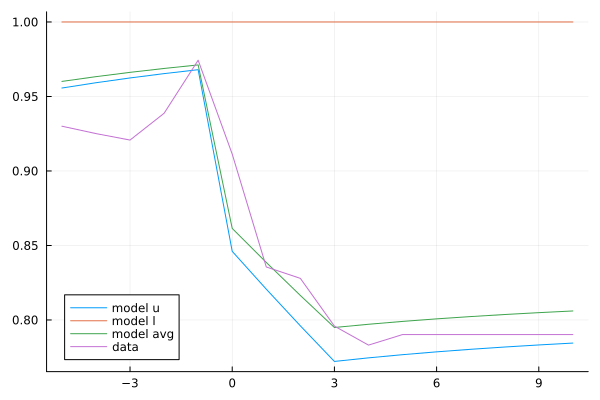

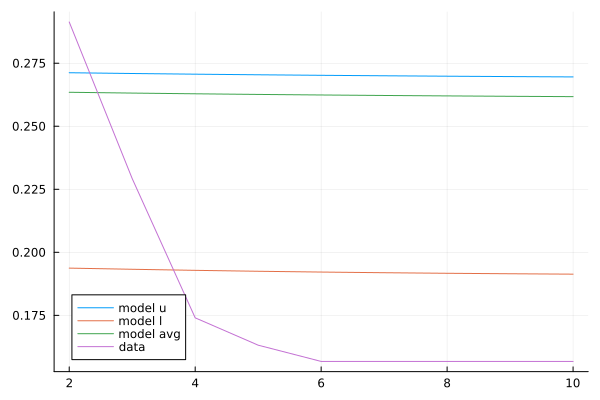

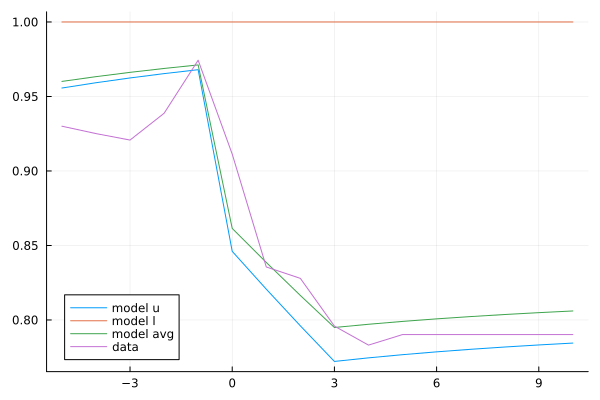

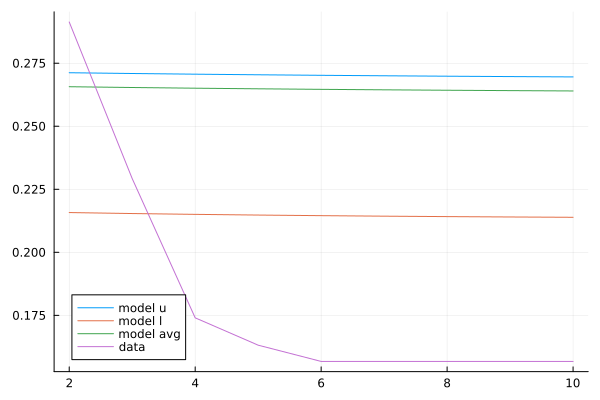

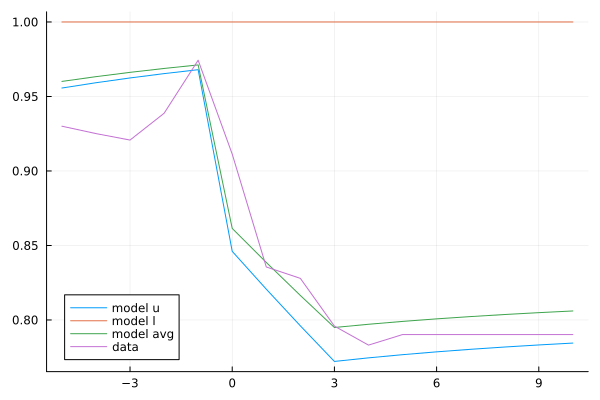

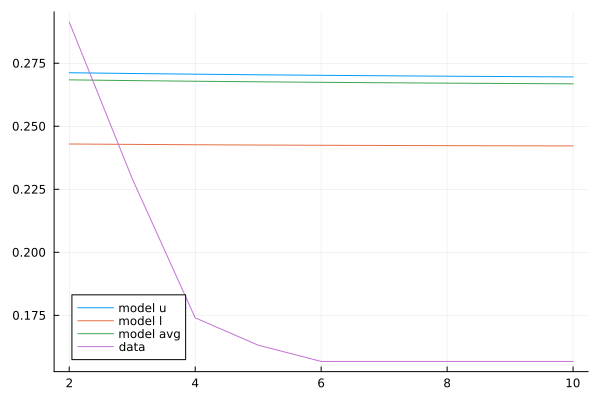

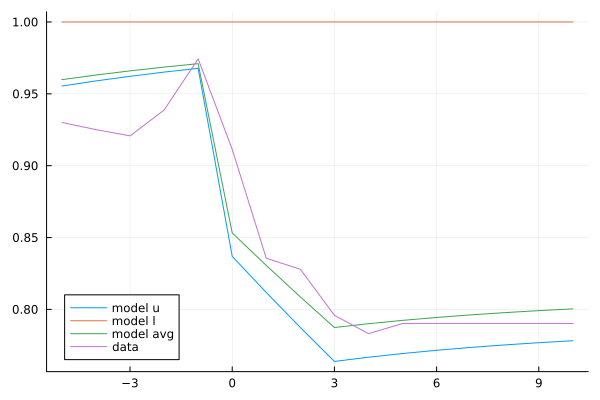

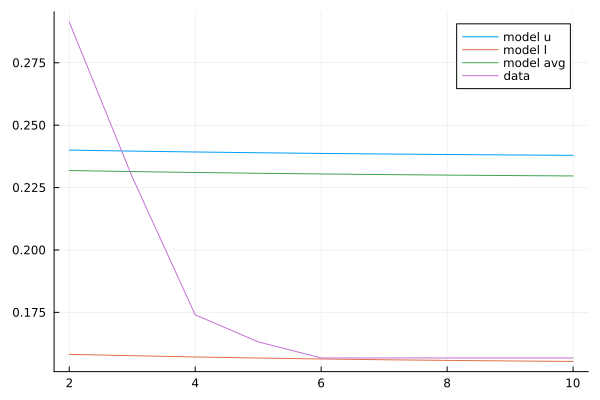

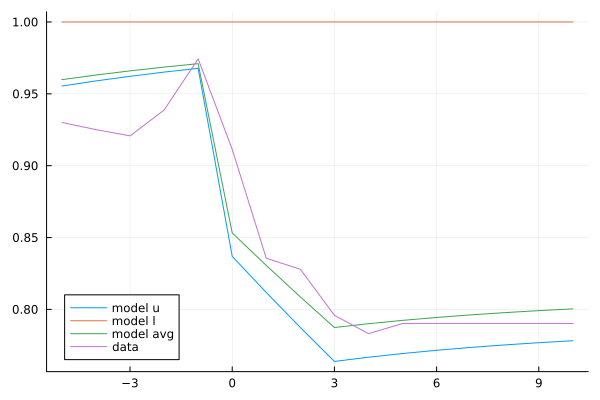

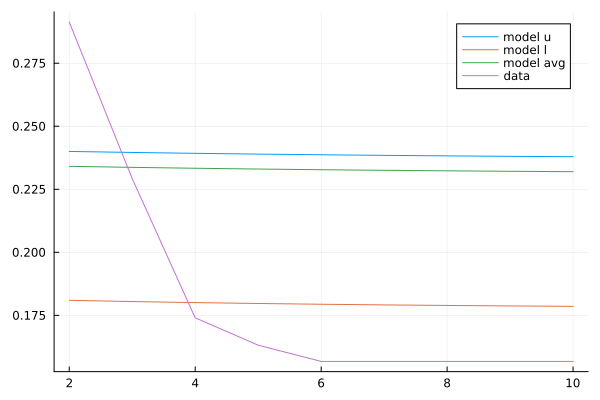

In [193]:
toR′ = load_object("toR.jld2")
toR′[100] .- toR[100]
res= [ x for x in get_mins(toR′,5,xshift=1)]
for x in res
    share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q = x
    c_sol,c_u_sol,c_l_sol,_,f_sol,f_u_sol,f_l_sol = moments_conso(share_u,βs,γs,χs,φs,yc,πec_q,πuc_q,πce_q)

    q = plot(months[2:end],c_u_sol[1:end-1],label="model u")
    plot!(q,months[2:end],c_l_sol[1:end-1],label="model l")
    plot!(q,months[2:end],c_sol[1:end-1],label="model avg")
    plot!(q,months[2:end],consos_norm[2:end],label="data")
    display(q)
    ind_u = findfirst(months[2:end].>0)
    q = plot(months[ind_u+2:end],f_u_sol[ind_u+2:end],label="model u")
    plot!(q,months[ind_u+2:end],f_l_sol[ind_u+2:end],label="model l")
    plot!(q,months[ind_u+2:end],f_sol[ind_u+2:end],label="model avg")
    plot!(q,months[ind_u+2:end],πue_ms[ind_u+1:end-1],label="data")
    display(q)
end

# CODE NOT UPDATED

The function 
> `elasticities(β,γ,R,πee,πuu; raw_indices_y=raw_indices_y)`

returns the elasticities of consumption (both employed and unemployed) to unemployment probability and unemployment transfer.

In [13]:
# NOT UPDATED
function elasticities(share_u,β_u,β_l,γ,yc,πec_q,πuc_q,πce_q;
        step_πeu = 1e-4,
        step_yu  = 0.01, 
        raw_indices_y=raw_indices_y,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πcu=0.,
        R=R_m,
        w=1.0,
        Tt=0.0,
        πeu_q=πeu_q,πue_q=πue_q)
    πeu_m,πue_m,πec_m,πuc_m,πce_m = transition_q_m(πeu_q,πue_q,πec_q,πuc_q,πce_q);
    eco_u_0 = Economy(β=β_u,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    eco_l_0 = Economy(β=β_l,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    sol_u_0 = steady(eco_u_0, noprint=true,tolSD=1e-12)
    sol_l_0 = steady(eco_l_0, noprint=true,tolSD=1e-12)
    @assert check_solution(sol_u_0,eco_u_0,noprint=true)
    @assert check_solution(sol_l_0,eco_l_0,noprint=true)   
    gc_u_0     = sol_u_0.gc
    statD_u_0 = sol_u_0.stationaryDist
    gc_l_0     = sol_l_0.gc
    statD_l_0 = sol_l_0.stationaryDist
    
    if (πeu_m+step_πeu) > one(πeu_q)
        @info("Problem with the step of the probability")
    end
    
    eco_u_π = Economy(β=β_u,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m+step_πeu,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    eco_l_π = Economy(β=β_l,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m+step_πeu,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    sol_u_π = steady(eco_u_π, noprint=true,tolSD=1e-12)
    sol_l_π = steady(eco_l_π, noprint=true,tolSD=1e-12)
    @assert check_solution(sol_u_π,eco_u_π,noprint=true)
    @assert check_solution(sol_l_π,eco_l_π,noprint=true)
    gc_u_π     = sol_u_π.gc
    statD_u_π = sol_u_π.stationaryDist
    gc_l_π     = sol_l_π.gc
    statD_l_π = sol_l_π.stationaryDist
    
    if path_to_u_res[1] > step_yu
        @info("Problem with the step of the unemployed income")
    end
    
    path_to_u_res′ = copy(path_to_u_res)
    path_to_u_res′[1] -= step_yu
    eco_u_y = Economy(β=β_u,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res′,
        πeu=πeu_m,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)
    eco_l_y = Economy(β=β_l,γ=γ,a_size=a_size,a_min=a_min,a_max=a_max,curv_a=curv_a,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res′,
        πeu=πeu_m,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R,w=w,Tt=Tt)   
    sol_u_y = steady(eco_u_y, noprint=true,tolSD=1e-12)
    sol_l_y = steady(eco_l_y, noprint=true,tolSD=1e-12)
    @assert check_solution(sol_u_y,eco_u_y,noprint=true)
    @assert check_solution(sol_l_y,eco_l_y,noprint=true)
    gc_u_y     = sol_u_y.gc
    statD_u_y = sol_u_y.stationaryDist
    gc_l_y     = sol_l_y.gc
    statD_l_y = sol_l_y.stationaryDist
    
    c_π(k) = share_u*sum(statD_u_π[:,k].*gc_u_π[:,k])/sum(statD_u_π[:,k]) + (
     (one(share_u)-share_u)*sum(statD_l_π[:,k].*gc_l_π[:,k])/sum(statD_l_π[:,k]))
    c_0(k) = share_u*sum(statD_u_0[:,k].*gc_u_0[:,k])/sum(statD_u_0[:,k]) + (
     (one(share_u)-share_u)*sum(statD_l_0[:,k].*gc_l_0[:,k])/sum(statD_l_0[:,k]))
    c_y(k) = share_u*sum(statD_u_y[:,k].*gc_u_y[:,k])/sum(statD_u_y[:,k]) + (
     (one(share_u)-share_u)*sum(statD_l_y[:,k].*gc_l_y[:,k])/sum(statD_l_y[:,k]))
    #=
    @show ((share_u*sum(statD_u_π.*gc_u_π)/sum(statD_u_π) + (
         (one(share_u)-share_u)*sum(statD_l_π.*gc_l_π)/sum(statD_l_π))) - (
            share_u*sum(statD_u_0.*gc_u_0)/sum(statD_u_0) + (
         (one(share_u)-share_u)*sum(statD_l_0.*gc_l_0)/sum(statD_l_0))
    ))/step_πeu
    
    @show size(statD_u_π)=#
    
    elasticity_π(k) = (c_π(k)/c_0(k)-1)/step_πeu
    elasticity_y(k) = (c_y(k)/c_0(k)-1)/(eco_u_y.ys[1]/eco_u_0.ys[1]-1)
    
    return elasticity_π,elasticity_y #(1),elasticity_π(6),elasticity_π(1:6),elasticity_y(1),elasticity_y(6),elasticity_y(1:6)
end;

## An example of simulated consumption path

In [141]:
#xres = (0.2, 0.9996, 0.93, 1.0, 0.4, 0.07, 0.14, 0.1)
#xres = (0.2, 0.999, 0.93, 1.0, 0.3, 0.07, 0.14, 0.1)
@nbinclude("SolveAiyagari_endo_effort.ipynb")

weights = ones(length(consos)-1)
weights[8:12] .= .2
xres = (0.3, 0.9997, 0.92, 1.1, 0.5, 0.07, 0.14, 0.1)
xres = (0.34, 0.9998, 0.86, 2.02, 0.59, 0.07, 0.14, 0.1)
#@show xres[2], dist_conso(xres...,weights=weights)
c_sol,c_u_sol,c_l_sol,_ = moments_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")
plot!(q,[months[2:end][times_e],months[2:end][times_e]],
    [minimum(consos_norm),maximum(consos_norm)],label="data")
plot!(q,[months[2:end][7],months[2:end][7]],
    [minimum(consos_norm),maximum(consos_norm)],label="data")
plot!(q,[months[2:end][8],months[2:end][8]],
    [minimum(consos_norm),maximum(consos_norm)],label="data")
plot!(q,[months[2:end][13],months[2:end][13]],
    [minimum(consos_norm),maximum(consos_norm)],label="data")
display(q)

q = plot(months[2:end],c_u_sol[1:end-1],label="model u")
plot!(q,months[2:end],c_l_sol[1:end-1],label="model l")
plot!(q,months[2:end],consos_norm[2:end],label="data")
display(q)

LoadError: MethodError: no method matching moments_conso(::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64)
[0mClosest candidates are:
[0m  moments_conso(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m; raw_indices_y, a_size, a_min, a_max, curv_a, times_to_u, path_to_u, πcu, R, w, Tt, πeu_q, πue_q) at In[139]:1

In [41]:
#πeu_m,πue_m,πec_m,πuc_m,πce_m = transition_q_m(πeu_q,πue_q,πec_q,πuc_q,πce_q);
eco_u = Economy(β=β_u,γ=γ,χ=1.0,φ=1.0,a_size=10,a_min=1e-9,a_max=1e3,curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,path_to_u=path_to_u_res,
        πeu=πeu_m,πue=πue_m,πec=πec_m,πuc=πuc_m,πce=πce_m,πcu=0.,
        yc=yc,R=R_m,w=1.0,Tt=0.)   
sol_u = steady(eco_u, noprint=true,tolSD=1e-12);


7-element Vector{Float64}:
 0.8904608426148267
 0.7996440534310761
 1.046698967161363
 1.1129470791840903
 1.0195807972013406
 1.0
 0.5

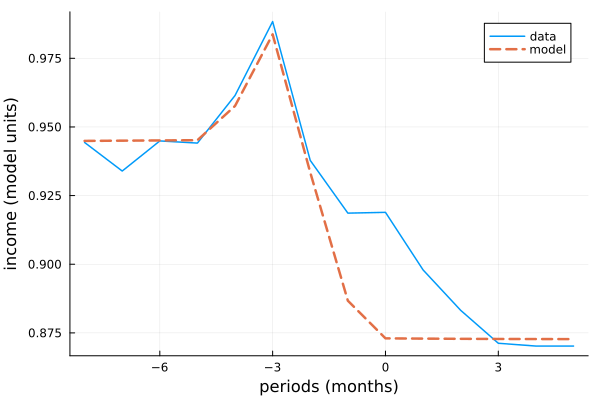

"/home/francois/Documents/Research/Models/WilnerBanking/French_data/julia/Code_one_good_endo-effort/conso_calibration.png"

In [17]:
q = plot(months[1:end-5], consos_norm[2:end-4],lw=1.5,label="data",ylabel="income (model units)",xlabel="periods (months)")
plot!(q,months[1:end-5],c_sol[1:end-5],lw=2.5,label="model",ls=:dash)
display(q)
savefig(q,"conso_calibration.png")

(xres[2], dist_conso(xres...)) = (0.9997, 0.07029736037389277)


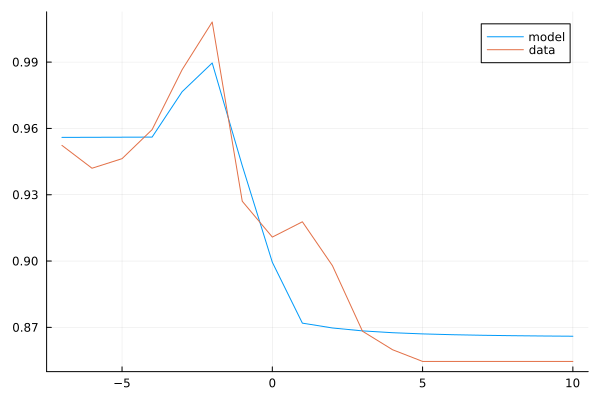

In [226]:
xres = [0.26, 0.9997, 0.94, 4.0, 1.0, 0.49, 0.49, 0.05, 0.05, 0.14, 0.1]
@show xres[2], dist_conso(xres...)
c_sol,_ = moments_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")
display(q)

## Heterogeneity in $y$

In [241]:
πuc_q = 0.14
πce_q = 1e-1
res = []
#[0.21, 0.9997, 0.88, 2.5, 2.5, 0.4, 0.9, 0.05, 0.05, 0.14, 0.1]
for share_u = 0.19:0.01:.22
    for β_u=0.9997:0.0001:0.9997
        for β_l = 0.86:0.01:0.92
            for γ = 2.0:0.25:3.0
                for yc_u = 0.3:0.1:0.5
                    for yc_l = 0.8:0.05:0.95
                        for πec_q = 0.05:0.01:0.05
                            if (yc_u <= 0.3)&&(γ >= 3.0)
                                continue
                            end
                            d = dist_conso(share_u,β_u,β_l,γ,γ,yc_u,yc_l,πec_q,πec_q,πuc_q,πce_q)
                            push!(res,(d,share_u,β_u,β_l,γ,γ,yc_u,yc_l,πec_q,πec_q,πuc_q,πce_q))
                        end
                    end
                end
            end
        end
    end
end
res

1568-element Vector{Any}:
 (0.07888541018904906, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.3, 0.8, 0.05, 0.05, 0.14, 0.1)
 (0.07886662235365226, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.3, 0.85, 0.05, 0.05, 0.14, 0.1)
 (0.07885101332046006, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.3, 0.9, 0.05, 0.05, 0.14, 0.1)
 (0.07883785431826115, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.3, 0.95, 0.05, 0.05, 0.14, 0.1)
 (0.07829720324069195, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.4, 0.8, 0.05, 0.05, 0.14, 0.1)
 (0.07828055167095267, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.4, 0.85, 0.05, 0.05, 0.14, 0.1)
 (0.07826670880911067, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.4, 0.9, 0.05, 0.05, 0.14, 0.1)
 (0.0782550285057393, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.4, 0.95, 0.05, 0.05, 0.14, 0.1)
 (0.08684616001208861, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.5, 0.8, 0.05, 0.05, 0.14, 0.1)
 (0.08683319351123414, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.5, 0.85, 0.05, 0.05, 0.14, 0.1)
 (0.08682240579881022, 0.19, 0.9997, 0.86, 2.0, 2.0, 0.5, 0.9, 0.05, 0.05, 0.14, 0.1)
 (0.08681329326794741, 0

In [240]:
@show mini_res = minimum([r[1] for r in res])
[r for r in res if r[1]==mini_res]

mini_res = minimum([r[1] for r = res]) = 0.06817391673839142


1-element Vector{NTuple{12, Float64}}:
 (0.06817391673839142, 0.21, 0.9997, 0.88, 2.5, 2.5, 0.4, 0.9, 0.05, 0.05, 0.14, 0.1)

(xres[2], dist_conso(xres...)) = (0.9997, 0.06979031220273813)


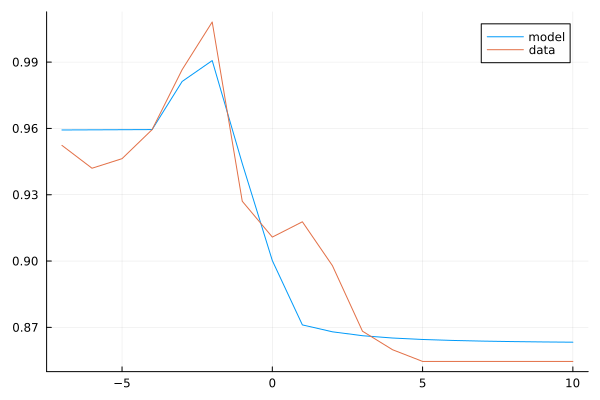

In [229]:
xres = [0.21, 0.9997, 0.89, 2.0, 2.0, 0.4, 0.6, 0.05, 0.05, 0.14, 0.1]
c_sol,_ = moments_conso(xres...)
@show xres[2], dist_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")

(xres[2], dist_conso(xres...)) = (0.9988, 0.05657308168717289)


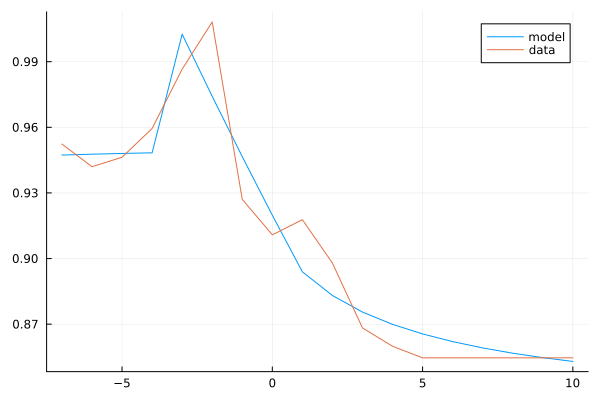

In [182]:
xres = [0.10479152086121886, 0.9988, 0.94, 2.0307911452369503, 0.20632357240024568, 0.012383996704455506, 1e-6, 1e-6]
c_sol,_ = moments_conso(xres...)
@show xres[2], dist_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")

(xres[2], dist_conso(xres...)) = (0.9989, 0.05646087717898436)


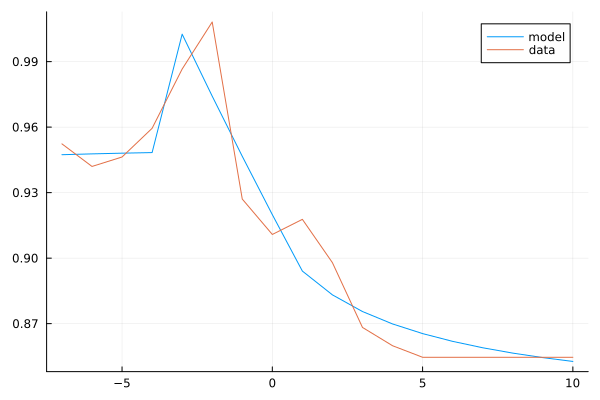

In [184]:
xres = [0.10318301472359256, 0.9989, 0.94, 2.0376236225468345, 0.19529576770300378, 0.011026138243863625, 1e-6, 1e-6]
c_sol,_ = moments_conso(xres...)
@show xres[2], dist_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")

(xres[2], dist_conso(xres...)) = (0.999, 0.05634274181745099)


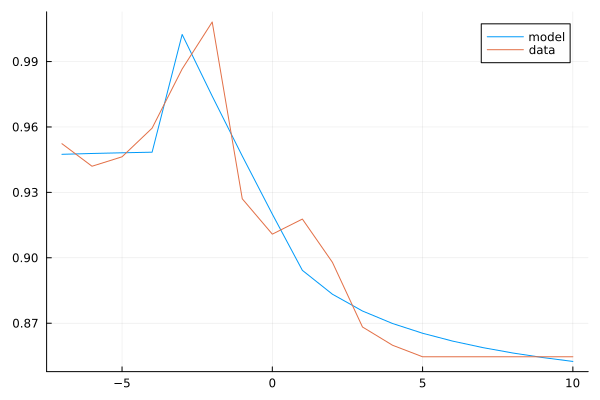

In [237]:
xres = [0.09834448236111706, 0.999, 0.95, 1.7031074719427237, 0.15953034011152128, 0.010888980128521847, 1e-6, 1e-6]
c_sol,_ = moments_conso(xres...)
@show xres[2], dist_conso(xres...)
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")
savefig(q,"estim.png")
display(q)

# Two-dimensional heterogeneity


$\beta$ and $y$

In [264]:
β_u,β_l = 0.997,0.89
x0 = [0.1481529026036932, 0.997, 0.89, 3.5059821502763495, 0.3920512149557585, 0.024265512911420373, 1e-6, 1e-6]
foo_π = x -> dist_conso(x[1],β_u,β_l,x[2:4]...,x[5],x[5],0.,0.)
#share_u,β_u,β_l,γ,yc_u,yc_l,πec_q_u,πec_q_l,πuc_q,πce_q
res = []
for share_u = 0.07:0.01:0.09
    for γ = 3.9:0.1:4.1
        for yc_u = 0.17:0.01:0.2
            for yc_l = 0.41:0.01:0.49
                for πec_q = 0.025:0.001:0.030
                    for πuc_q = 10.0.^(-6:2:-6)
                        for πce_q = 10.0.^(-6:2:-6)
                            d = dist_conso(share_u,β_u,β_l,γ,yc_u,yc_l,πec_q,πec_q,πuc_q,πce_q)
                            push!(res,(d,share_u,β_u,β_l,γ,yc_u,yc_l,πec_q,πec_q,πuc_q,πce_q))
                        end
                    end
                end
            end
        end
    end
end
res

1944-element Vector{Any}:
 (0.09320201365358709, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.025, 0.025, 1.0e-6, 1.0e-6)
 (0.10153610416338107, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.026, 0.026, 1.0e-6, 1.0e-6)
 (0.10983377786067793, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.027, 0.027, 1.0e-6, 1.0e-6)
 (0.11800119596934819, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.028, 0.028, 1.0e-6, 1.0e-6)
 (0.12598312266948494, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.029, 0.029, 1.0e-6, 1.0e-6)
 (0.1337482961156505, 0.07, 0.997, 0.89, 3.9, 0.17, 0.41, 0.03, 0.03, 1.0e-6, 1.0e-6)
 (0.07307137615429482, 0.07, 0.997, 0.89, 3.9, 0.17, 0.42, 0.025, 0.025, 1.0e-6, 1.0e-6)
 (0.07992228914171648, 0.07, 0.997, 0.89, 3.9, 0.17, 0.42, 0.026, 0.026, 1.0e-6, 1.0e-6)
 (0.0872269148777892, 0.07, 0.997, 0.89, 3.9, 0.17, 0.42, 0.027, 0.027, 1.0e-6, 1.0e-6)
 (0.0947350266813889, 0.07, 0.997, 0.89, 3.9, 0.17, 0.42, 0.028, 0.028, 1.0e-6, 1.0e-6)
 (0.10228669602366319, 0.07, 0.997, 0.89, 3.9, 0.17, 0.42, 0.029, 0.029, 1.0e-6, 1.0e-6)


In [265]:
res[end]

(0.09011805136119573, 0.09, 0.997, 0.89, 4.1, 0.2, 0.49, 0.03, 0.03, 1.0e-6, 1.0e-6)

x_mini = ([r for r = res if r[1] == minimum([r[1] for r = res])])[1] = (0.056317193873668535, 0.08, 0.997, 0.89, 4.0, 0.18, 0.45, 0.028, 0.028, 1.0e-6, 1.0e-6)
(x_mini[2], dist_conso(x_mini[2:end]...), x_mini[1]) = (0.08, 0.056317193873668535, 0.056317193873668535)


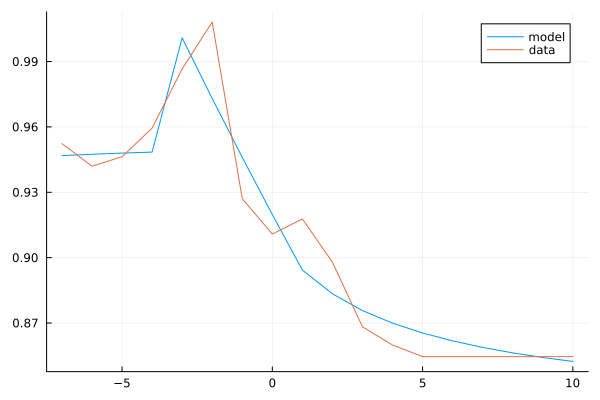

In [266]:
#share_u,β_u,β_l,γ,yc_u,yc_l,πec_q_u,πec_q_l,πuc_q,πce_q
@show x_mini = [r for r in res if r[1]==minimum([r[1] for r in res])][1]
#x_mini = (0.05654368283356166, 0.08, 0.997, 0.89, 3.8, 0.18, 0.43, 0.027, 0.027, 1.0e-6, 1.0e-6)
c_sol,_ = moments_conso(x_mini[2:end]...)
@show x_mini[2], dist_conso(x_mini[2:end]...),x_mini[1]
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")

x_mini = ([r for r = res if r[1] == minimum([r[1] for r = res])])[1] = (0.05653163099362393, 0.08, 0.997, 0.89, 3.9, 0.2, 0.45, 0.03, 0.03, 1.0e-6, 1.0e-6)
(x_mini[2], dist_conso(x_mini[2:end]...), x_mini[1]) = (0.08, 0.05653163099362393, 0.05653163099362393)


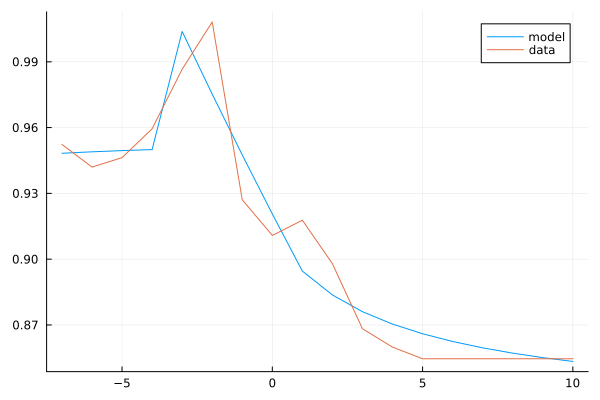

In [245]:
#share_u,β_u,β_l,γ,yc_u,yc_l,πec_q_u,πec_q_l,πuc_q,πce_q
@show x_mini = [r for r in res if r[1]==minimum([r[1] for r in res])][1]
c_sol,_ = moments_conso(x_mini[2:end]...)
@show x_mini[2], dist_conso(x_mini[2:end]...),x_mini[1]
q = plot(months[2:end],c_sol[1:end-1],label="model")
plot!(q,months[2:end],consos_norm[2:end],label="data")

In [247]:
res = []
#share_u,β_u,β_l,γ,yc_u,yc_l,πec_q_u,πec_q_l,πuc_q,πce_q
for β_u=0.997:0.001:0.997
    miniβ_l = 1e100
    for β_l = 0.89:0.01:0.89
        #foo_π = x -> dist_conso(x[1],β_u,β_l,x[2:4]...,x[5],x[5],x[6],x[7])
        #res_min = Optim.optimize(foo_π, [0.08, 0.997, 0.89, 3.9, 0.2, 0.45, 0.03, 0.03, 1.0e-6, 1.0e-6])
        foo_π = x -> dist_conso(x[1],β_u,β_l,x[2:4]...,x[5],x[5],1e-6,1e-6)
        res_min = Optim.optimize(foo_π, [0.08, 0.997, 0.89, 3.9, 0.2, 0.45, 0.03, 0.03])
        @show Optim.converged(res_min), res_min.minimum, res_min.minimizer
        xres = res_min.minimizer
        fres = res_min.minimum
        push!(res,(res_min.minimum,xres[1],β_u,β_l,xres[2:end]...))
        if fres > miniβ_l
            break
        else
            miniβ_l = fres
        end
    end
end

res

[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[

(Optim.converged(res_min), res_min.minimum, res_min.minimizer) = (true, 0.0632489460556655, [0.15147785673477135, 2.544498004837811, 0.6917526364341036, 0.9323980457801336, 0.9813799073445839, 0.4287529639657362, -0.0817114506982273, -0.010748138381888532])


[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 
[ Info: 


1-element Vector{Any}:
 (0.0632489460556655, 0.15147785673477135, 0.997, 0.89, 2.544498004837811, 0.6917526364341036, 0.9323980457801336, 0.9813799073445839, 0.4287529639657362, -0.0817114506982273, -0.010748138381888532)

In [200]:
function test(x1,x2,x3,x4,x5)
    return 1
end
x = [2,3,4]
test(1,x[1:2]...,3,x[end])


1

## The not-normalized case

In [26]:
βs = 0.99:-0.01:0.95
x0 = [0.4,0.65]
optis = []
for (k,β) in enumerate(βs)
    opti = Optim.optimize(x -> dist_conso(β,x[1],x[2],normalized=false)[1], x0)
    push!(optis, (β,opti))
    x0 = opti.minimizer
end

(β, γ, yc, _) = res[1] = (0.99, 0.43239444682549244, 0.6435632540873486, 0.14379447168621487)


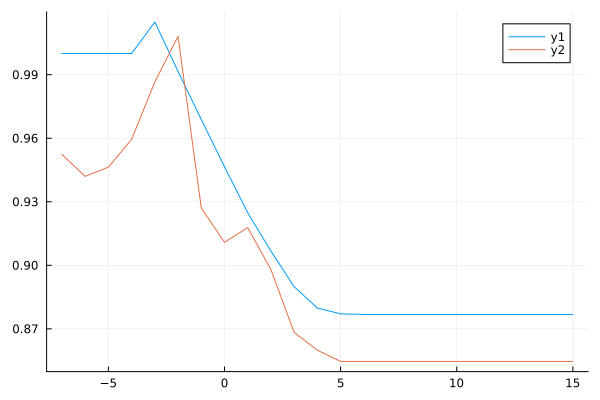

In [27]:
min_opti = minimum([opti.minimum for (β,opti) in optis])
res    = [(β,opti.minimizer...,opti.minimum) for (β,opti) in optis if opti.minimum == min_opti]
@assert length(res)==1

@show β,γ,yc,_ = res[1]
#(β, γ, πcu, yc) = (0.96, 1.3361978861154769, 0.8667656448066452, 0.41927229717111786)
R,πec,πuc, = 1.0,0.0,0.06
y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
#c_ref = mean(c_sol[1:4])
c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end]#.*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=false)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5 ≈ min_opti
display(q);

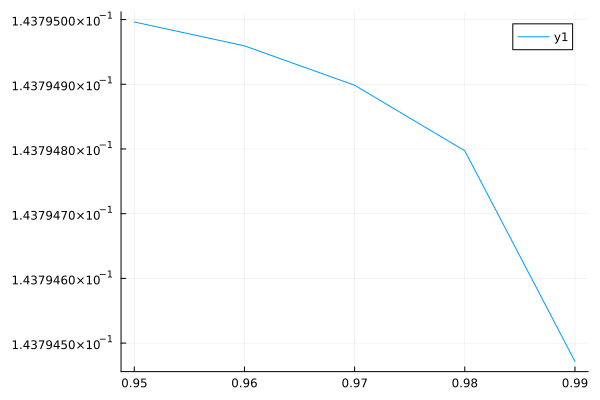

In [28]:
plot([β for (β,opti) in optis],[opti.minimum for (β,opti) in optis])

(β, γ, yc, _) = res[1] = (0.97, 1.3120963027808006, 0.6725968247871171, 0.14379489844405874)


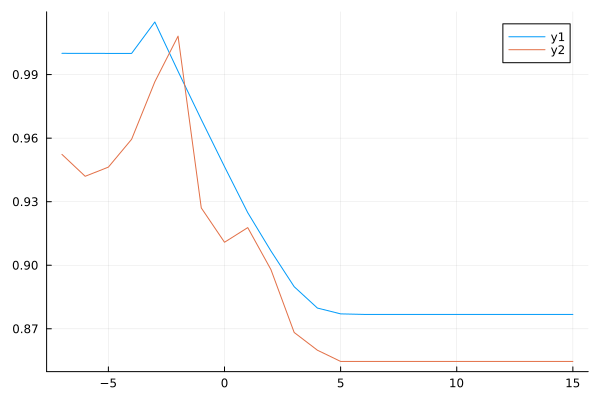

In [29]:
res    = [(β,opti.minimizer...,opti.minimum) for (β,opti) in optis if β == 0.97]
@assert length(res)==1

@show β,γ,yc,_ = res[1]
#(β, γ, πcu, yc) = (0.96, 1.3361978861154769, 0.8667656448066452, 0.41927229717111786)

y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
#c_ref = mean(c_sol[1:4])
c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end]#.*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=false)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5
display(q);

In [42]:
βs = 0.995:0.001:0.999
x0 = [0.2,0.63]
optis = []
for (k,β) in enumerate(βs)
    opti = Optim.optimize(x -> dist_conso(β,x[1],x[2],normalized=false)[1], x0)
    push!(optis, (β,opti))
    x0 = opti.minimizer
end

(β, γ, yc, _) = res[1] = (0.999, 0.04305887955033853, 0.6275474350828247, 0.1437939261148151)


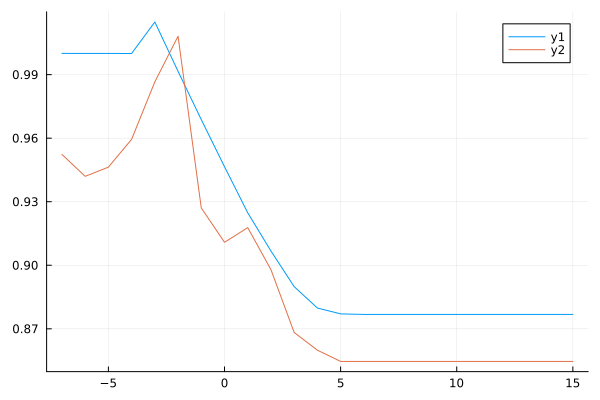

In [39]:
min_opti = minimum([opti.minimum for (β,opti) in optis])
res    = [(β,opti.minimizer...,opti.minimum) for (β,opti) in optis if opti.minimum == min_opti]
@assert length(res)==1

@show β,γ,yc,_ = res[1]
#(β, γ, πcu, yc) = (0.96, 1.3361978861154769, 0.8667656448066452, 0.41927229717111786)
R,πec,πuc, = 1.0,0.0,0.06
y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
#c_ref = mean(c_sol[1:4])
c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end]#.*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=false)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5 ≈ min_opti
display(q);

# The normalized case

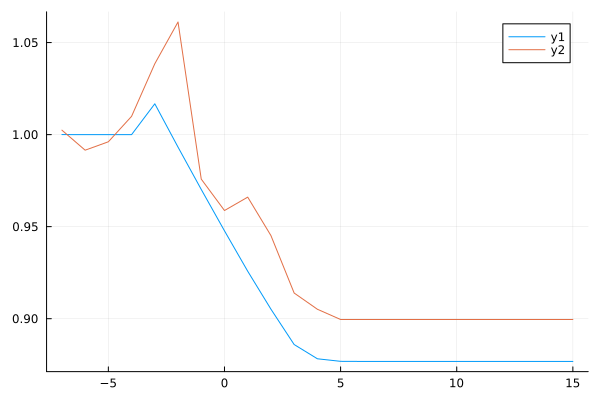

In [30]:
β,γ,yc = 0.97, 1.3, 0.7
y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
c_ref = mean(c_sol[1:4])
#c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=true)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5
display(q);

In [31]:
βs = 0.99:-0.01:0.95
x0 = [0.4,0.65]
optis = []
for (k,β) in enumerate(βs)
    opti = Optim.optimize(x -> dist_conso(β,x[1],x[2],normalized=true)[1], x0)
    push!(optis, (β,opti))
    x0 = opti.minimizer
end

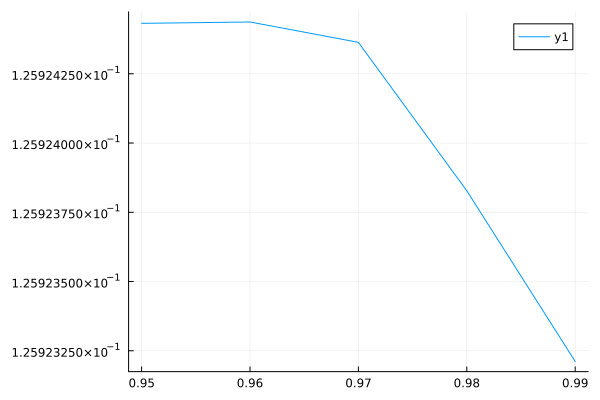

In [32]:
plot([β for (β,opti) in optis],[opti.minimum for (β,opti) in optis])

(β, γ, yc, _) = res[1] = (0.99, 0.41225557821744585, 0.6488017060008133, 0.12592321146630192)


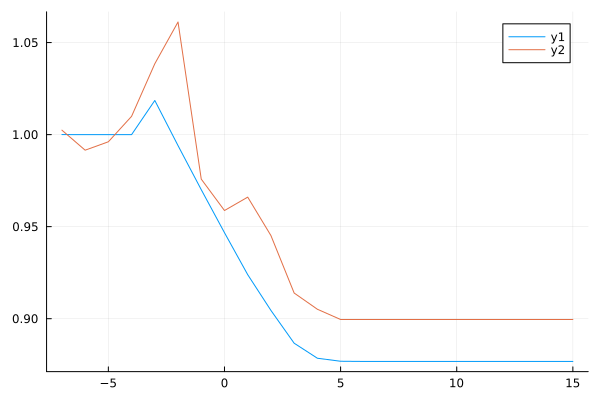

In [33]:
min_opti = minimum([opti.minimum for (β,opti) in optis])
res    = [(β,opti.minimizer...,opti.minimum) for (β,opti) in optis if opti.minimum == min_opti]
@assert length(res)==1

@show β,γ,yc,_ = res[1]
#(β, γ, πcu, yc) = (0.96, 1.3361978861154769, 0.8667656448066452, 0.41927229717111786)
R,πec,πuc, = 1.0,0.0,0.06
y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=true)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5 ≈ min_opti
display(q);

(β, γ, yc, _) = res[1] = (0.97, 1.2490716225379066, 0.675369669336092, 0.12592436345247854)


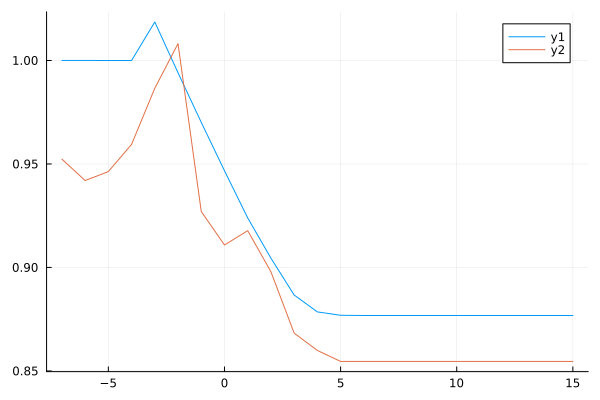

In [34]:
res    = [(β,opti.minimizer...,opti.minimum) for (β,opti) in optis if β == 0.97]
@assert length(res)==1

@show β,γ,yc,_ = res[1]
#(β, γ, πcu, yc) = (0.96, 1.3361978861154769, 0.8667656448066452, 0.41927229717111786)

y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,πec_m,πuc_m,πce_m,πcu_m)
#c_ref = mean(c_sol[1:4])
c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end]#.*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@assert dist_conso(β,γ,yc,normalized=false)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5
display(q);

In [89]:
1/0.999

1.001001001001001

01. Gini                               0.1345
08. Aggregate labor supply, L          0.906
09. Average MPC                        0.0071
14. Share of credit-constrained agents 0.01%
sum(solution.stationaryDist[:, end - 1] .* solution.gc[:, end - 1]) / sum(solution.stationaryDist[:, end - 1]) = 0.9467799181711646
sum(solution.stationaryDist[:, end - 1] .* solution.ga[:, end - 1]) / sum(solution.stationaryDist[:, end - 1]) = 41.942948643551055
c_sol[1] = 0.9467799181744169


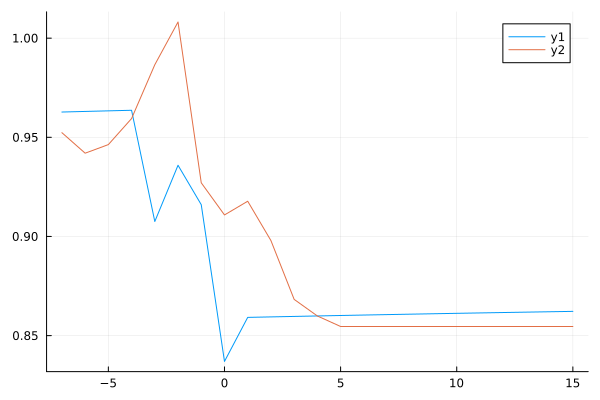

In [121]:
(β, γ, yc) = (0.998, 1.7, 0.01)
economy = Economy(
        β=β,
        γ=γ,
        a_size=100,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        πee=πee_m,
        πuu=πuu_m,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πec=0.8,
        πuc=πuc_m,
        πce=πce_m,
        πcu=πcu_m,        
        yc=yc,
        R=R_m,
        w=1.0,
        Tt=0.);
solution = steady(economy, print_step=200, noprint=true);
@assert check_solution(solution,economy,noprint=true)
print_dict(describe_solution(solution,economy))
@show sum(solution.stationaryDist[:,end-1].*solution.gc[:,end-1])/sum(solution.stationaryDist[:,end-1])
@show sum(solution.stationaryDist[:,end-1].*solution.ga[:,end-1])/sum(solution.stationaryDist[:,end-1])
y_sol,c_sol = moments_conso(β,γ,yc,R_m,πee_m,πuu_m,0.8,πuc_m,πce_m,πcu_m)
@show c_sol[1]
#c_ref = mean(c_sol[1:4])
c_ref = 1.0
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end]#.*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],0.7.*c_sol_ + 0.3*y_sol[1:end-1])
plot!(q,months[2:end],consos_norm_)
#@assert dist_conso(β,γ,yc,normalized=false,)[1] ≈ sum((c_sol_ - consos_norm_).^2)^0.5
display(q);

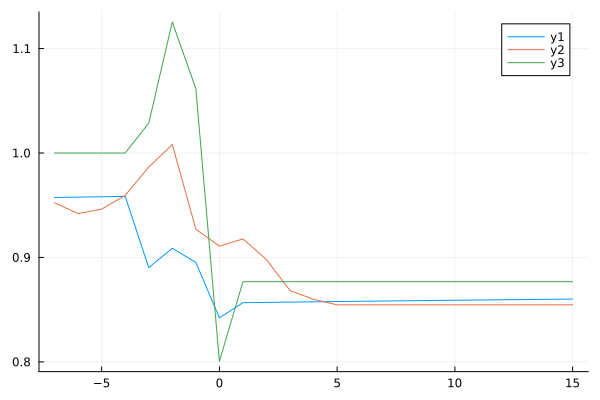

In [123]:
q = plot(months[2:end],0.8.*c_sol_ + 0.2*y_sol[1:end-1])
plot!(q,months[2:end],consos_norm_)
plot!(q,months[2:end],y_sol[1:end-1])


2 pops
* hetregenous beta
* find shares
* see whethe \pi_ec is needed

# Old stuff

In [113]:
function transition_q_m(πeu_q,πue_q,πce_q,πec_m,πuc_m)
    function foo(πeu,πue,πce)
        eco = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu,
        πue=πue,
        πec=πec_m,
        πuc=πuc_m,
        πce=πce,
        πcu=0.,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
        Πy_q = eco.Πy^3
        #=return (sum(Πy_q[end-1,1:end-2]) - πeu_q, 
                Πy_q[1,end-1] - πue_q)#,
               #Πy_q[end-1,end] - πec_q)#,
               # Πy_q[1,end] - πuc_q,
                # Πy_q[end,end-1] - πce_q)=#
        return ((sum(Πy_q[end-1,1:end-2]) - πeu_q)^2 + 
            (Πy_q[1,end-1] - πue_q)^2 + 
            (Πy_q[end,end-1] - πce_q)^2)^0.5
    end
    #res  = nlsolve(x -> foo(x...),.1*ones(Float64,2))
    #return res.zero #Optim.minimizer(res)
    res  = optimize(x -> foo(x...),[1-(1-πeu_q)^(1/3.), 1-(1-πue_q)^(1/3.),πce_q/3.])
    return Optim.minimizer(res)
end
πec_m,πuc_m = 0.1,0.1
πeu_m,πue_m,πce_m = transition_q_m(πeu_q,πue_q,πce_q,πec_m,πuc_m);
@show πeu_m,πue_m,πec_m,πuc_m
#[1-πeu_m πeu_m;πue_m 1-πue_m]^3  - [1-πeu_q πeu_q;πue_q 1-πue_q]
economy = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu_m,
        πue=πue_m,
        πec=πec_m,
        πuc=πuc_m,
        πcu=0.,
        πce=πce_m,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
Πy_q = economy.Πy^3
@show sum(Πy_q[end-1,1:end-2])-πeu_q,Πy_q[1,end-1]-πue_q,Πy_q[end,end-1]-πce_q#,Πy_q[end-1,end]-πec_q, Πy_q[1,end]-πuc_q
economy.Πy^3

(πeu_m, πue_m, πec_m, πuc_m) = (0.006677490329072146, 0.12605014520726124, 0.1, 0.1)
(sum(Πy_q[end - 1, 1:end - 2]) - πeu_q, Πy_q[1, end - 1] - πue_q, Πy_q[end, end - 1] - πce_q) = (-1.3725617073467866e-8, 8.256262729045005e-9, 1.7066672547416673e-8)


7×7 Matrix{Float64}:
 0.463595  0.0  0.0         0.000841699  0.00143188   0.275     0.259132
 0.598998  0.0  0.0         0.0          0.000841699  0.214434  0.185726
 0.77395   0.0  0.0         0.0          0.0          0.12605   0.1
 1.0       0.0  0.0         0.0          0.0          0.0       0.0
 0.0       1.0  0.0         0.0          0.0          0.0       0.0
 0.0       0.0  0.00667749  0.00596515   0.00535734   0.724621  0.257379
 0.0       0.0  0.0         0.000285386  0.000528131  0.11      0.889186

In [134]:
function transition_q_m(πeu_q,πue_q,πce_q,πec_q,πuc_m)
    function foo(πeu,πue,πce,πec)
        eco = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu,
        πue=πue,
        πec=πec,
        πuc=πuc_m,
        πce=πce,
        πcu=0.,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
        Πy_q = eco.Πy^3
        #=return (sum(Πy_q[end-1,1:end-2]) - πeu_q, 
                Πy_q[1,end-1] - πue_q)#,
               #Πy_q[end-1,end] - πec_q)#,
               # Πy_q[1,end] - πuc_q,
                # Πy_q[end,end-1] - πce_q)=#
        return ((sum(Πy_q[end-1,1:end-2]) - πeu_q)^2 + 
            (Πy_q[1,end-1] - πue_q)^2 + 
            (Πy_q[end,end-1] - πce_q)^2 + (Πy_q[end-1,end]-πec_q)^2)^0.5
    end
    #res  = nlsolve(x -> foo(x...),.1*ones(Float64,2))
    #return res.zero #Optim.minimizer(res)
    res  = optimize(x -> foo(x...),[1-(1-πeu_q)^(1/3.), 1-(1-πue_q)^(1/3.),πce_q/3., 1-(1-πec_q)^(1/3.)])
    return Optim.minimizer(res)
end
πec_q,πuc_m = 0.25,0.01
πeu_m,πue_m,πce_m,πec_m = transition_q_m(πeu_q,πue_q,πce_q,πec_q,πuc_m);
@show πeu_m,πue_m,πec_m,πuc_m
#[1-πeu_m πeu_m;πue_m 1-πue_m]^3  - [1-πeu_q πeu_q;πue_q 1-πue_q]
economy = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu_m,
        πue=πue_m,
        πec=πec_m,
        πuc=πuc_m,
        πcu=0.,
        πce=πce_m,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
Πy_q = economy.Πy^3
diffs = sum(Πy_q[end-1,1:end-2])-πeu_q,Πy_q[1,end-1]-πue_q,Πy_q[end,end-1]-πce_q,Πy_q[end-1,end]-πec_q#, Πy_q[1,end]-πuc_q
@show diffs
@show maximum(abs.([diffs...]))#, Πy_q[1,end]-πuc_q
economy.Πy^

(πeu_m, πue_m, πec_m, πuc_m) = (0.006655595268431602, 0.11629883788618181, 0.09678865063755265, 0.01)
diffs = (-9.730495145743312e-9, 2.8760580583764295e-9, 1.9326654415730005e-8, 4.466874786723807e-8)
maximum(abs.([diffs...])) = 4.466874786723807e-8


7×7 Matrix{Float64}:
 0.873701  0.0  0.0  0.0  0.0        0.116299  0.01
 1.0       0.0  0.0  0.0  0.0        0.0       0.0
 0.0       1.0  0.0  0.0  0.0        0.0       0.0
 0.0       0.0  1.0  0.0  0.0        0.0       0.0
 0.0       0.0  0.0  1.0  0.0        0.0       0.0
 0.0       0.0  0.0  0.0  0.0066556  0.896556  0.0967887
 0.0       0.0  0.0  0.0  0.0        0.042587  0.957413

In [149]:
function transition_q_m(πeu_q,πue_q,πce_q,πuc_q,πec_m)
    function foo(πeu,πue,πce,πuc)
        eco = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu,
        πue=πue,
        πec=πec_m,
        πuc=πuc,
        πce=πce,
        πcu=0.,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
        Πy_q = eco.Πy^3
        #=return (sum(Πy_q[end-1,1:end-2]) - πeu_q, 
                Πy_q[1,end-1] - πue_q)#,
               #Πy_q[end-1,end] - πec_q)#,
               # Πy_q[1,end] - πuc_q,
                # Πy_q[end,end-1] - πce_q)=#
        return ((sum(Πy_q[end-1,1:end-2]) - πeu_q)^2 + 
            (Πy_q[1,end-1] - πue_q)^2 + 
            (Πy_q[end,end-1] - πce_q)^2 + (Πy_q[1,end]-πuc_q)^2)^0.5
    end
    #res  = nlsolve(x -> foo(x...),.1*ones(Float64,2))
    #return res.zero #Optim.minimizer(res)
    res  = optimize(x -> foo(x...),[1-(1-πeu_q)^(1/3.), 1-(1-πue_q)^(1/3.),πce_q/3., 1-(1-πuc_q)^(1/3.)])
    return Optim.minimizer(res)
end
πec_m,πuc_q = 0.0,0.05
πeu_m,πue_m,πce_m,πuc_m = transition_q_m(πeu_q,πue_q,πce_q,πuc_q,πec_m);
@show πeu_m,πue_m,πec_m,πuc_m
#[1-πeu_m πeu_m;πue_m 1-πue_m]^3  - [1-πeu_q πeu_q;πue_q 1-πue_q]
economy = Economy(
        β=0.97,
        γ=2.0,
        a_size=10,
        a_min=1e-9,
        a_max=1e3,
        curv_a=4.0,
        times_to_u=length(path_to_u_res)-1,
        path_to_u=path_to_u_res,
        πeu=πeu_m,
        πue=πue_m,
        πec=πec_m,
        πuc=πuc_m,
        πcu=0.,
        πce=πce_m,
        yc=0.01,
        R=1.0,
        w=1.0,
        Tt=0.0);
Πy_q = economy.Πy^3
diffs = sum(Πy_q[end-1,1:end-2])-πeu_q,Πy_q[1,end-1]-πue_q,Πy_q[end,end-1]-πce_q,Πy_q[1,end]-πuc_q#, Πy_q[1,end]-πuc_q
@show diffs
@show maximum(abs.([diffs...]))#, Πy_q[1,end]-πuc_q
economy.Πy

(πeu_m, πue_m, πec_m, πuc_m) = (0.006036371249307173, 0.10385856069306774, 0.0, 0.01971834900243849)
diffs = (2.036629778712218e-8, 2.6870364544517855e-8, 2.4271813184317814e-8, 2.6140273501340516e-8)
maximum(abs.([diffs...])) = 2.6870364544517855e-8


7×7 Matrix{Float64}:
 0.876423  0.0  0.0  0.0  0.0         0.103859   0.0197183
 1.0       0.0  0.0  0.0  0.0         0.0        0.0
 0.0       1.0  0.0  0.0  0.0         0.0        0.0
 0.0       0.0  1.0  0.0  0.0         0.0        0.0
 0.0       0.0  0.0  1.0  0.0         0.0        0.0
 0.0       0.0  0.0  0.0  0.00603637  0.993964   0.0
 0.0       0.0  0.0  0.0  0.0         0.0383464  0.961654

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.043914691275540686, true)


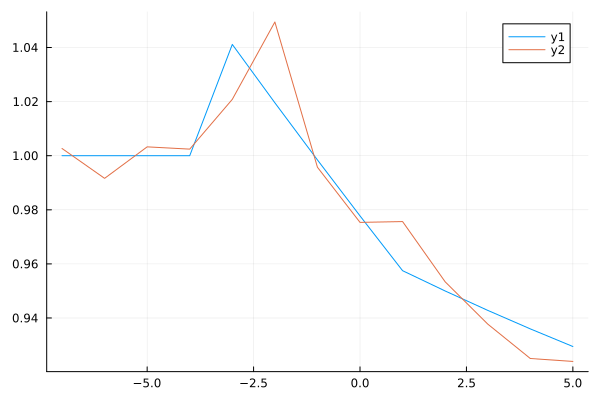

In [655]:
β,γ,R,πuu = 0.99,0.48,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005,0.005,0.001,0.0569
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.043632182206585865, true)


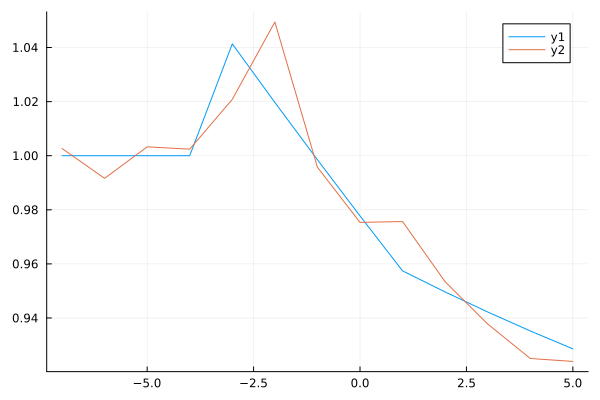

In [645]:
β,γ,R,πuu = 0.97,1.45,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005,0.005,0.001,0.187
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.04350076831770831, true)


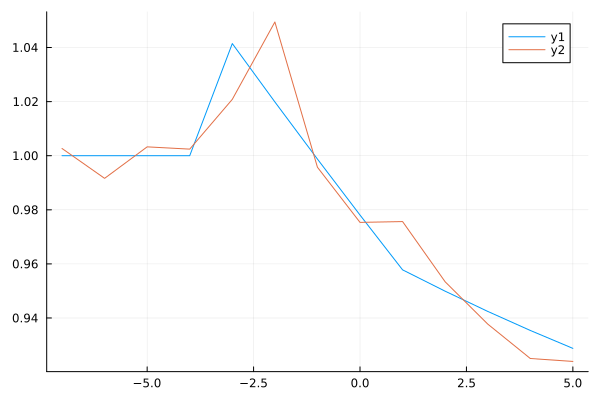

In [637]:
β,γ,R,πuu = 0.96,1.95,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005,0.005,0.001,0.2397
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.040685802308929785, true)


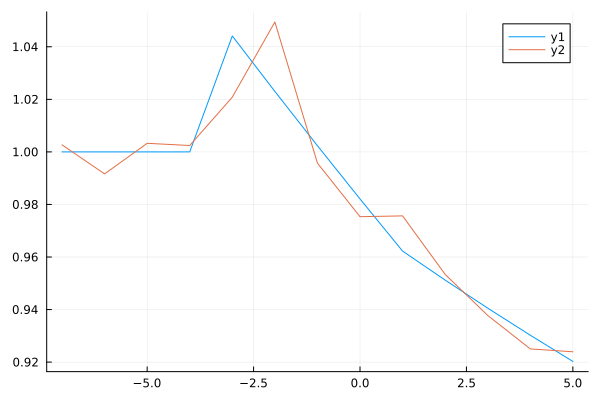

In [610]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005, 0.004, 0.009,0.25413
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.043519613183543505, true)


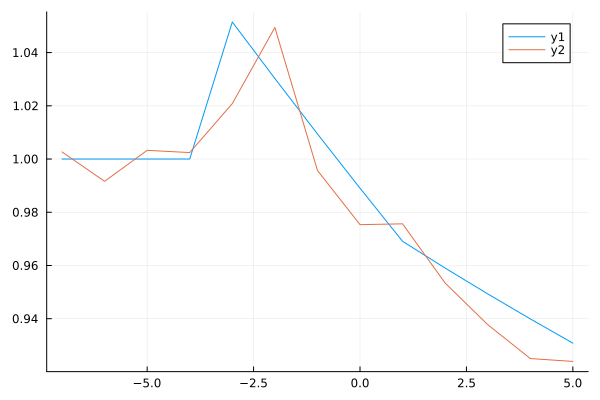

In [535]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m-0.05
πec,πuc,πcu,yc = 0.006, 0.006, 0.001,0.27355
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.04082258106574608, true)


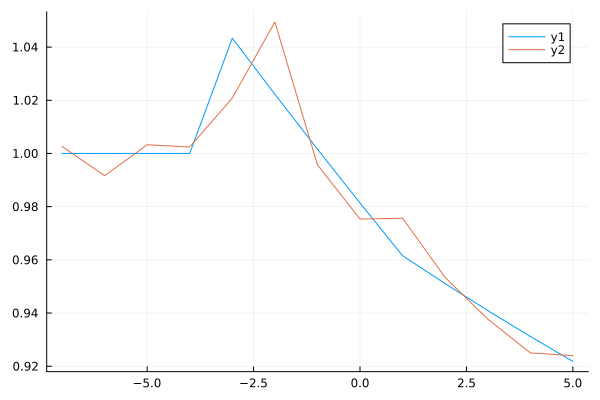

In [504]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.006, 0.005, 0.01,0.27726
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.05146267980625197, true)


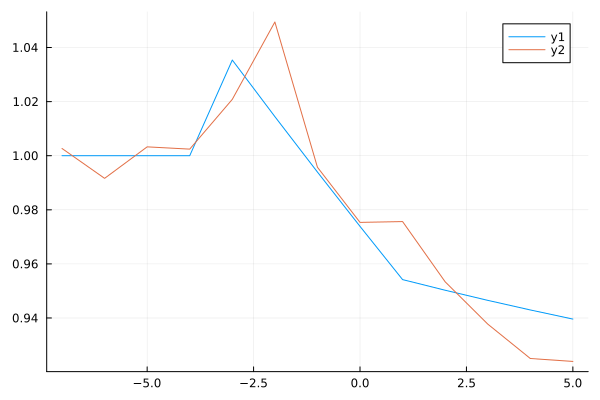

In [489]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.006, 0.005, 0.001,0.129
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.1177571782281355, false)


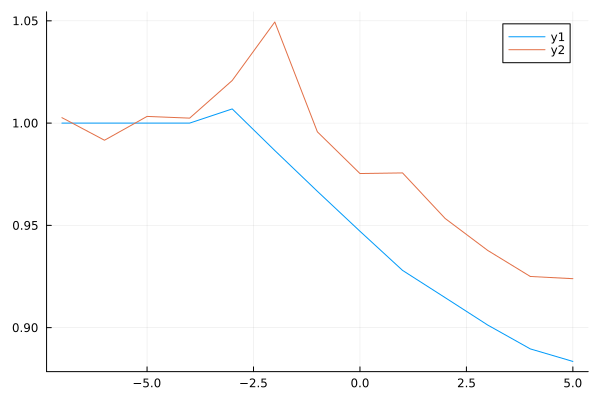

In [485]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.007, 0.005, 0.001,0.3193
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.040777678708852245, true)


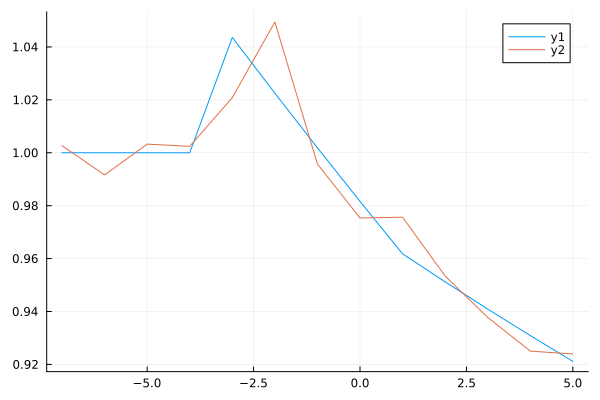

In [481]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.006, 0.005, 0.001,0.28401
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.1177571782281354, false)


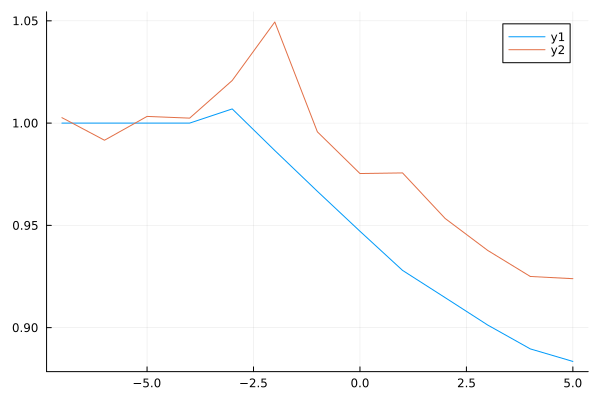

In [470]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.001, 0.005, 0.001,0.3193
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.043572820599657544, true)


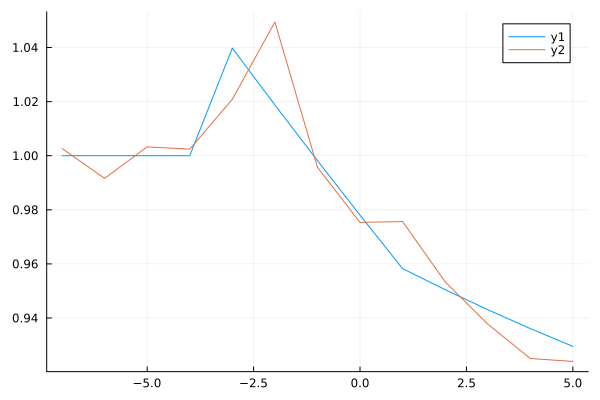

In [466]:
β,γ,R,πuu = 0.96,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005, 0.005, 0.001,0.2484
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.049106930592666014, true)


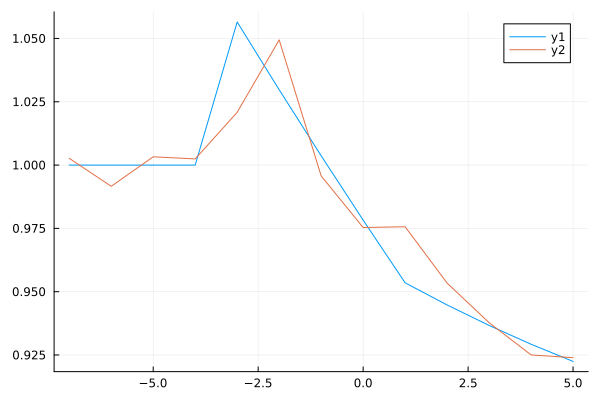

In [459]:
β,γ,R,πuu = 0.95,2.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005, 0.005, 0.001,0.21338
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.04716704040709254, true)


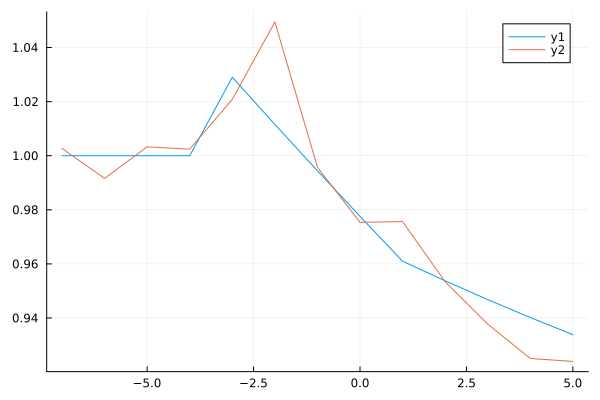

In [445]:
β,γ,R,πuu = 0.95,3.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005, 0.005, 0.001,0.3554
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.047346401061663004, true)


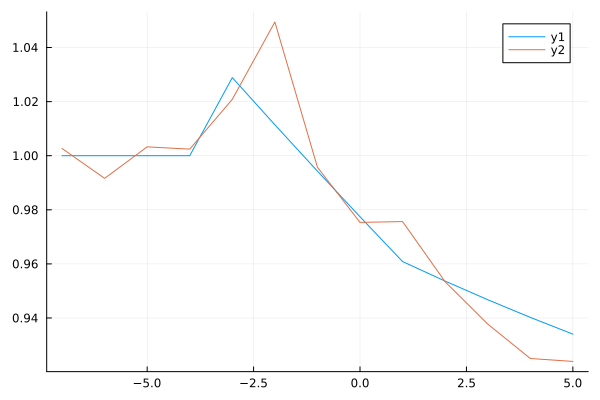

In [436]:
β,γ,R,πuu = 0.95,3.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.005, 0.005, 0.01,0.3464
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.04782787790977073, true)


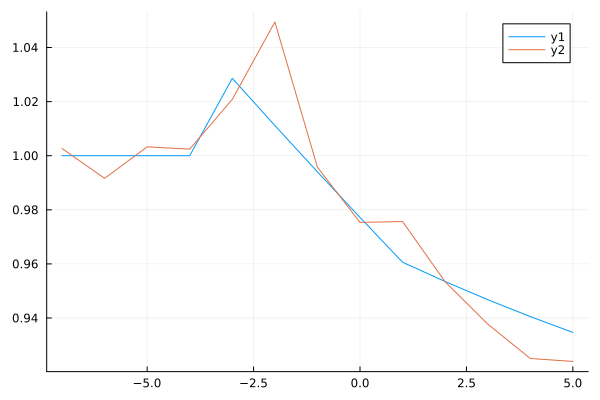

In [421]:
β,γ,R,πuu = 0.95,3.0,1.0,1-πue_m
πec,πuc,πcu,yc = 0.001, 0.001, 0.01,0.1805
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

In [349]:
dist_conso(0.99,1.4,1.0,0.001, 0.001, 0.1,0.000001)

(0.09838740926895578, false)

(d, check) = dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.06353995637576555, false)


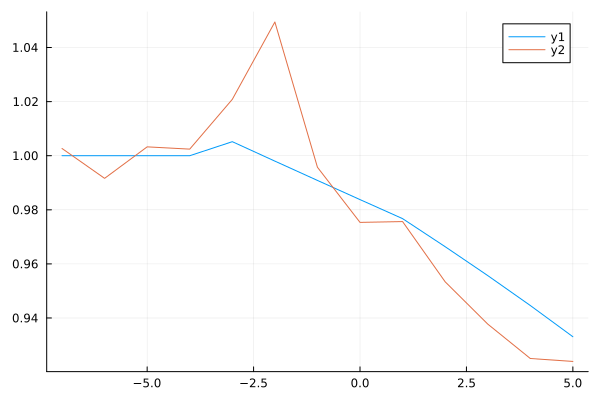

In [335]:
β,γ,R = 0.99,1.4,1.0
πuu,πec,πuc,πcu,yc = 1-πue_m,0.016773107534695235, 0.00, 0.9625178684419872, 0.0005612494545482193
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show d,check = dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

(d, check) = dist_conso(β, γ, R, πec, πuc, πcu, yc) = (0.11785032716092995, false)


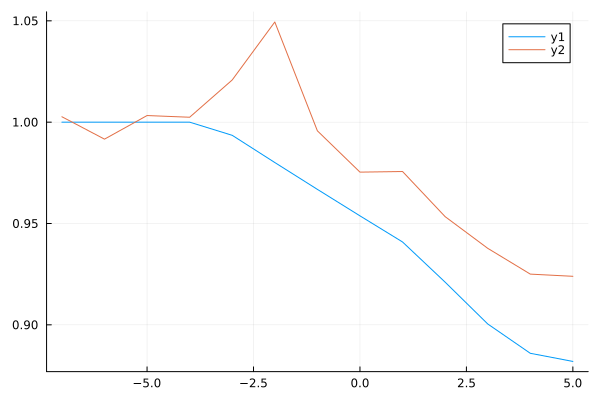

In [326]:
β,γ,R = 0.96,3.0,1.0
πuu,πec,πuc,πcu,yc = 1-πue_m,0.01, 0.00, 0.5, 0.8
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,πuu,πec,πuc,πcu,yc)
c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
@show d,check = dist_conso(β,γ,R,πec,πuc,πcu,yc)
display(q);

## Exploring the possible parameter values

In [186]:
res = []
R = 1.0
for β = 0.81:0.05:.97
    for γ=0.5:0.5:3.5
        for yc = 0.01:0.1:0.5
            for πec = 0.001:0.005:0.021
                for πuc = 0.001:0.005:0.021
                    for πcu = 0.01:0.02:0.05
                        d,check = dist_conso(β,γ,R,πec,πuc,πcu,yc)
                        check && push!(res,(β,γ,R,πec,πuc,πcu,yc,d))
                    end
                end
            end
        end
    end
end
res

4953-element Vector{Any}:
 (0.81, 0.5, 1.0, 0.001, 0.001, 0.01, 0.01, 0.24830091055138506)
 (0.81, 0.5, 1.0, 0.001, 0.001, 0.03, 0.01, 0.24830091055138515)
 (0.81, 0.5, 1.0, 0.001, 0.001, 0.05, 0.01, 0.24830091055138495)
 (0.81, 0.5, 1.0, 0.001, 0.006, 0.01, 0.01, 0.24830091055138506)
 (0.81, 0.5, 1.0, 0.001, 0.006, 0.03, 0.01, 0.24830091055138512)
 (0.81, 0.5, 1.0, 0.001, 0.006, 0.05, 0.01, 0.24830091055138503)
 (0.81, 0.5, 1.0, 0.001, 0.011, 0.01, 0.01, 0.24830091055138506)
 (0.81, 0.5, 1.0, 0.001, 0.011, 0.03, 0.01, 0.24830091055138506)
 (0.81, 0.5, 1.0, 0.001, 0.011, 0.05, 0.01, 0.24830091055138503)
 (0.81, 0.5, 1.0, 0.001, 0.016, 0.01, 0.01, 0.24830091055138506)
 (0.81, 0.5, 1.0, 0.001, 0.016, 0.03, 0.01, 0.2483009105513851)
 (0.81, 0.5, 1.0, 0.001, 0.016, 0.05, 0.01, 0.2483009105513851)
 (0.81, 0.5, 1.0, 0.001, 0.021, 0.01, 0.01, 0.24830091055138512)
 ⋮
 (0.96, 0.5, 1.0, 0.021, 0.006, 0.01, 0.41, 0.15913101838269653)
 (0.96, 0.5, 1.0, 0.021, 0.006, 0.03, 0.41, 0.15913101838269664

#### Saving the results

In [59]:
fname = "dist_cons.csv"
dirpath = "./data"
fpath = joinpath(dirpath, fname)

open(fpath, "w") do io
    for line in res
        println(io,reduce((x,y) -> x*","*y,string.(line)))
    end
end



In [60]:
fname = "dist_cons.csv"
dirpath = "./data"
fpath = joinpath(dirpath, fname)
res = []
open(fpath, "r") do io
    for line in readlines(io)
        push!(res,map(x->parse(Float64,x),split(line,",")))
    end
end


## Plotting the results

(β, γ, R, πec, πuc, πcu, yc, d) = res_min[1] = (0.86, 3.5, 1.0, 0.001, 0.006, 0.01, 0.41, 0.13431118929515612)


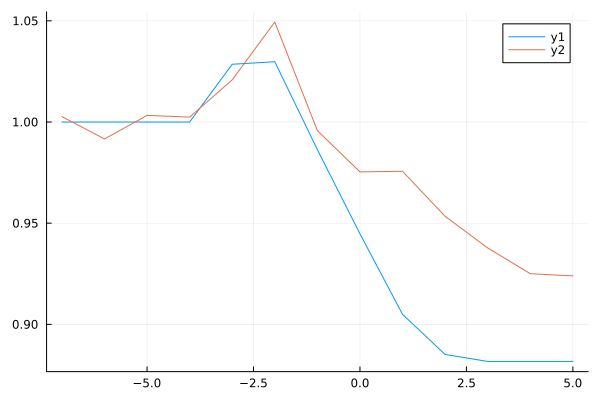

In [187]:
min_dist = minimum([r[end] for r in res])
res_min = [r for r in res if r[end]==min_dist]
#@show β,γ,R,πee,πuu,d = res_min[1]
#y_sol,c_sol = moments_conso(β,γ,R,πee,πuu)
@show β,γ,R,πec,πuc,πcu,yc,d = res_min[1]
y_sol,c_sol = moments_conso(β,γ,R,1-πeu_m,1-πue_m,πec,πuc,πcu,yc)

c_ref = mean(c_sol[1:4])
c_sol_ = c_sol[1:end-1]./c_ref
consos_norm_ = consos_norm[2:end].*c_ref./mean(consos_norm[2:5])
#consos_norm_ = consos_norm[1:end-1].*c_ref./mean(consos_norm[1:4])
q = plot(months[2:end],c_sol_)
plot!(q,months[2:end],consos_norm_)
display(q);

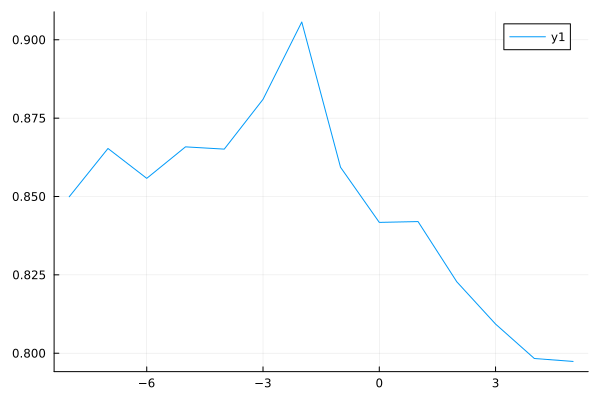

In [723]:
plot(months,consos_norm)

# Numerical applications <a id="Numerical-applications"></a> [<font size=1>(back to steady state)</font>](#solving-steady-state)

We conduct two applications: [the first one](#numeric-application-1)  checks that previous functions are correct and [the second one](#numeric-application-2) is more quantitative.

### First application <a id="numeric-application-1"></a>[<font size=1>(back to numerical applications)</font>](#Numerical-applications)

We compute the paths of durable and nondurable consumption, as well as of savings 
We check that when we initialize the paths of savbings and durable consumption using the function  `long_term_value` we actually get a flat path.

raw_to_full([2, 2, 1], economy) = [2, 2, 1]
toR = 1.8846386214007957
toR = 1.34269490696546


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


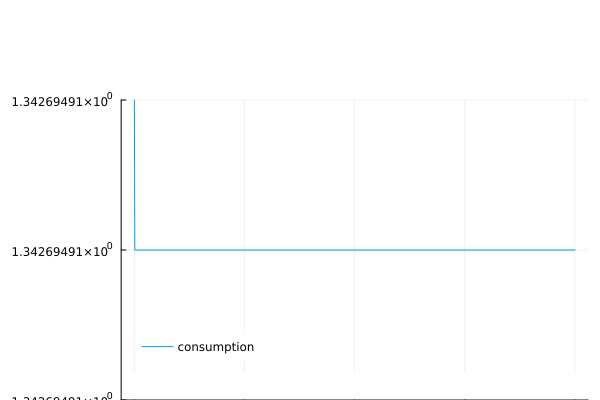

GKS: Possible loss of precision in routine SET_WINDOW


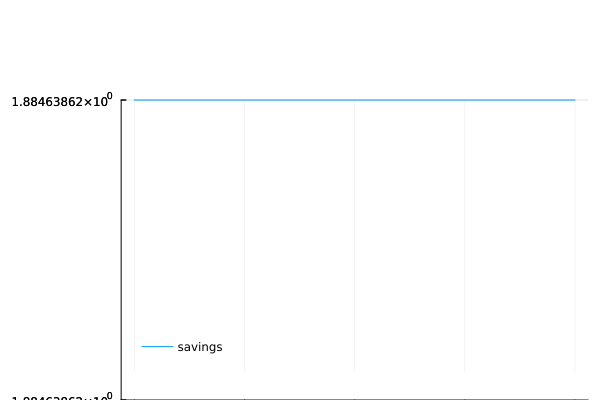

In [9]:
# path of income
@nbinclude("Utils.ipynb"); 
y_path_raw = fill(2,1000)

# initialization of saving and durable consumption paths using long_term_value
a0 = long_term_value(2,solution,policy=:ga)
c0 = long_term_value(2,solution,policy=:gc)


t0 = findfirst(y_path_raw[2:end].<y_path_raw[1:end-1])

# we include possible severance periods
y_path = raw_to_full(y_path_raw,economy)

# we compute paths
a_path,c_path = paths(y_path,a0,c0,solution,economy)

# plots
q = plot(0:length(y_path), c_path,label="consumption",fg_legend = :false)
display(q)
q = plot(0:length(y_path), a_path,label="savings",fg_legend = :false)
display(q)

### Second application <a id="numeric-application-2"></a>[<font size=1>(back to numerical applications)</font>](#Numerical-applications)